# Regression Discontinuity with GLMs and Kernel Weighting


In this notebook we explore [regression discontinuity design](https://en.wikipedia.org/wiki/Regression_discontinuity_design) using [generalized linear models (GLMs)](https://en.wikipedia.org/wiki/Generalized_linear_model) and kernel weighting from a bayesian perspective. The motivation comes from applications when:

1. The data does not fit the usual linear regression OLS normal likelihood (e.g. modeling count data).
2. The data size is limited.

In addition, we experiment with kernel weighting to weight the data points near the cutoff more heavily. This is a common technique in RD analysis, but it is not always clear how to do this with GLMs in the bayesian framework. We show how to do this with the [PyMC](https://www.pymc.io/welcome.html).

**TL;DR:** I took quite a while to run various experiments by changing the data size and the data generation process. Overall, my personal take is that the vanilla regression discontinuity approach via OLS is quite robust and might fit most of the cases (of course, it really depends on the data and the context). The power of the GLM bayesian approach comes when one (or both) of  the conditions mentioned above hold. Moreover, the approach presented is quite flexible and can be tailored to the specific problem at hand.

**Remark:** There two main motivations to look into this topic:
- A real life application in the context of epidemiology where I was an advisor.
- The sequence of blog posts by [Solomon Kruz](https://solomonkurz.netlify.app/) on causal inference and bayesian GLMs (strongly recommended!). For an introduction to the topic please see my two notes replicating  Solomon's  great work in Python: [ATE Estimation with Logistic Regression](https://juanitorduz.github.io/causal_inference_logistic/) and [ATE Estimation for Count Data](https://juanitorduz.github.io/causal_inference_negative_binomial/).

## References

Here we do not go into a detailed discussion of regression discontinuity, but we refer the reader to the following great online resources:

- [Causal Inference for The Brave and True  - Chapter 16](https://matheusfacure.github.io/python-causality-handbook/16-Regression-Discontinuity-Design.html)
- [Causal Inference: The Mixtape  - Chapter 6](https://mixtape.scunning.com/06-regression_discontinuity)
- [The Effect: An Introduction to Research Design and Causality  - Chapter 20](https://theeffectbook.net/ch-RegressionDiscontinuity.html)

Please also check out [`CausalPy`](https://causalpy.readthedocs.io/en/latest/) for a basic bayesian implementation of regression discontinuity for normal likelihoods.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
# set seed to make the results fully reproducible!
seed: int = sum(map(ord, "regression_discontinuity_glm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


## Data Generation

We use a synthetic data set to illustrate the ideas. The approach is an adaptation  of the data generation process presented in the [Causal Inference: The Mixtape  - Chapter 6](https://mixtape.scunning.com/06-regression_discontinuity#estimation-using-an-rdd). The main difference is that we add higher order polynomial terms to add  non-linearity to the data.

In [3]:
# number of observations
n = 80
# cutoff index
c = 40
# treatment effect
delta = 40

# running variable
x = rng.uniform(low=-20, high=80, size=n)
# treatment indicator
d = (x > c).astype(float)

# polynomial coefficients
intercept = 25
slope = 2
quadratic = -4e-3
cubic = 3e-4

# outcome without treatment
y0 = (
    intercept
    + slope * x
    + quadratic * x**2
    + cubic * x**3
    + 0 * d
    + rng.normal(loc=0, scale=30, size=n)
)
# outcome with treatment
y = y0 + delta * d

data = pd.DataFrame(data={"x": x, "d": d, "y0": y0, "y": y})
mask = "0 < y0 and 0 < y"
data = data.query(expr=mask).sort_values(by="x").reset_index(drop=True)
# add centered running variable
data["x_c"] = data["x"] - c

# (re)compute the true discontinuity
y_minus = intercept + slope * c + quadratic * c**2
y_plus = y_minus + delta
delta_true = y_plus - y_minus

print(
    f"""
Discontinuity at x = {c}
-----------------------
y_minus: {y_minus:.2f}
-----------------------
y_plus: {y_plus:.2f}
-----------------------
delta_true: {delta_true:.2f}
-----------------------
"""
)



Discontinuity at x = 40
-----------------------
y_minus: 98.60
-----------------------
y_plus: 138.60
-----------------------
delta_true: 40.00
-----------------------



Let's look into the data with and without the treatment effect.

[Text(0.5, 1.0, 'Treatment Effect'), Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

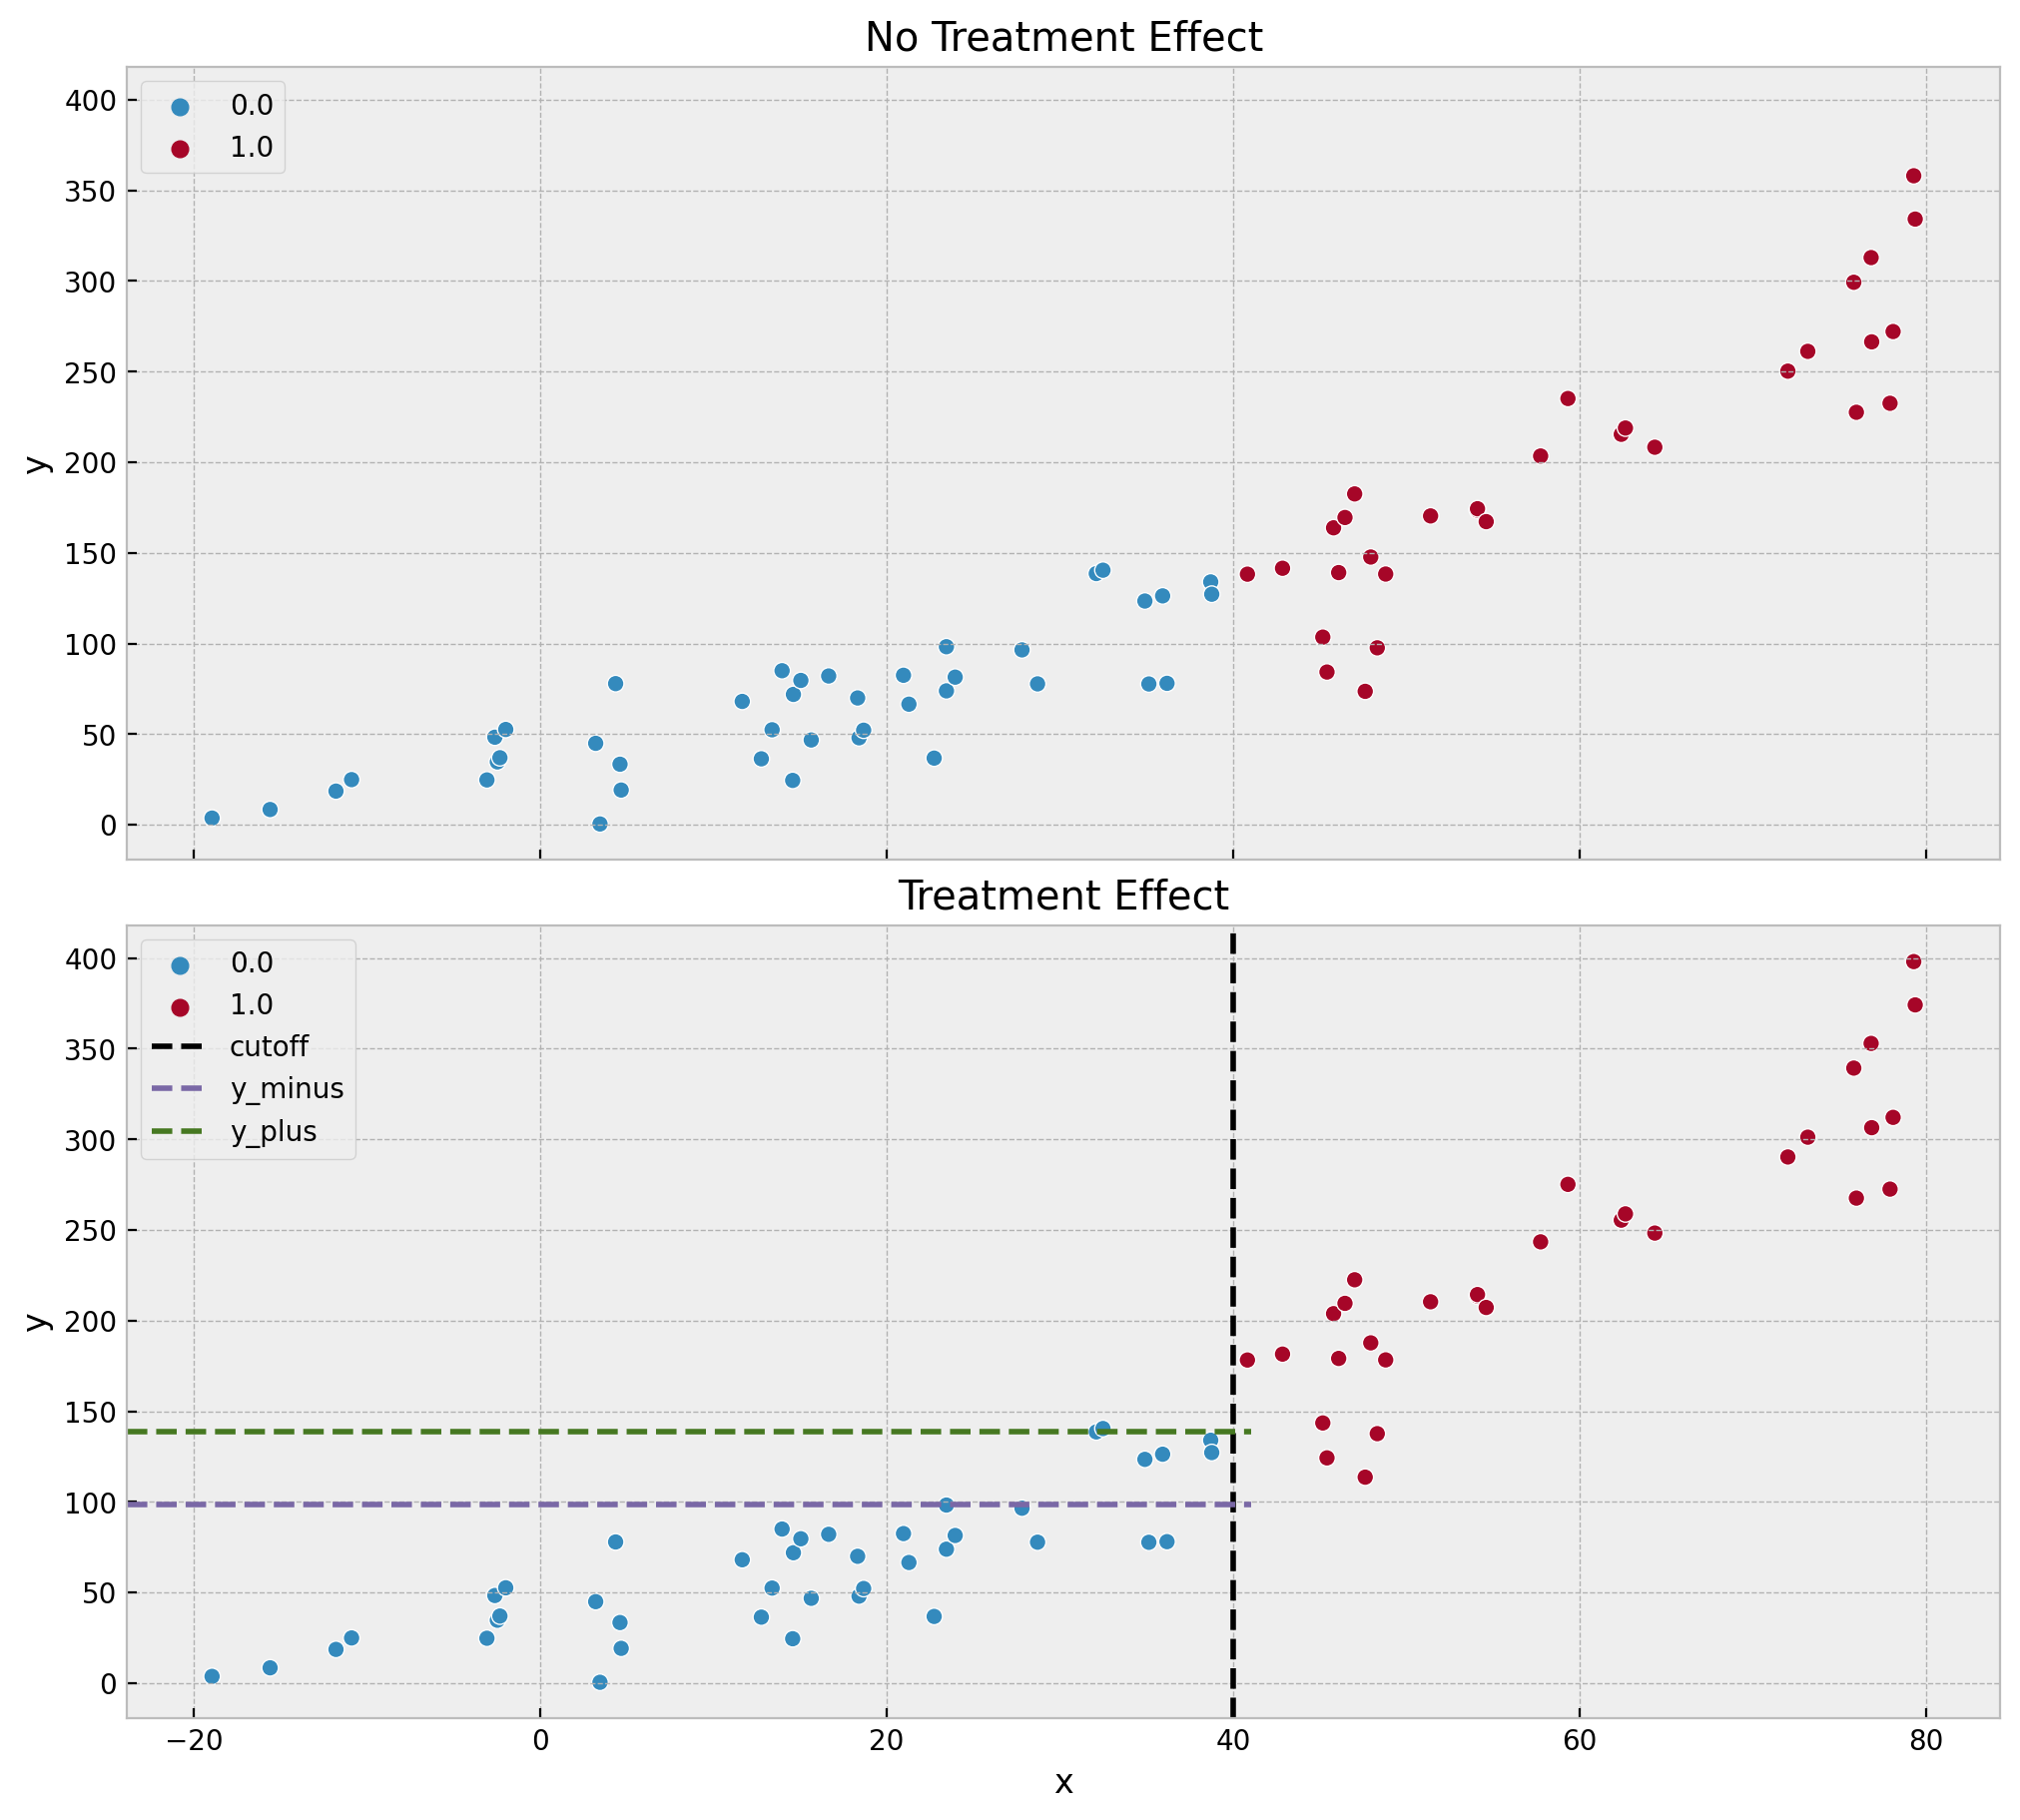

In [39]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 9), layout="constrained"
)
sns.scatterplot(data=data, x="x", y="y0", hue="d", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(title="No Treatment Effect", xlabel="x", ylabel="y")
sns.scatterplot(data=data, x="x", y="y", hue="d", ax=ax[1])
ax[1].axvline(x=c, color="black", linestyle="--", label="cutoff")
ax[1].axhline(
    y=y_minus,
    xmax=0.6,
    color="C2",
    linestyle="--",
    label="y_minus",
)
ax[1].axhline(
    y=y_plus,
    xmax=0.6,
    color="C3",
    linestyle="--",
    label="y_plus",
)
ax[1].legend(loc="upper left")
ax[1].set(title="Treatment Effect", xlabel="x", ylabel="y")


Here are some comments and remarks about this synthetic data set:
- We  do not have a lot of observations (not uncommon in real applications).
- We are assuming the $y$ variable is non-negative by nature (e.g. university scores). Hence, any model used to explain the data should ideally reflect this fact as there is some non-linearity in the data coming from this fact.
- We do see an apparent discontinuity in the data: both in the intercept and the slope. We are not interested in the point estimate of the treatment effect, but rather in the uncertainty around it.

We can zoom in and focus on the variable $y$. As explained below, it is convenient to work with the centered version of the running variable $x$, so that the cutoff is at zero.

[Text(0.5, 1.0, 'Centered Synthetic Data'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y')]

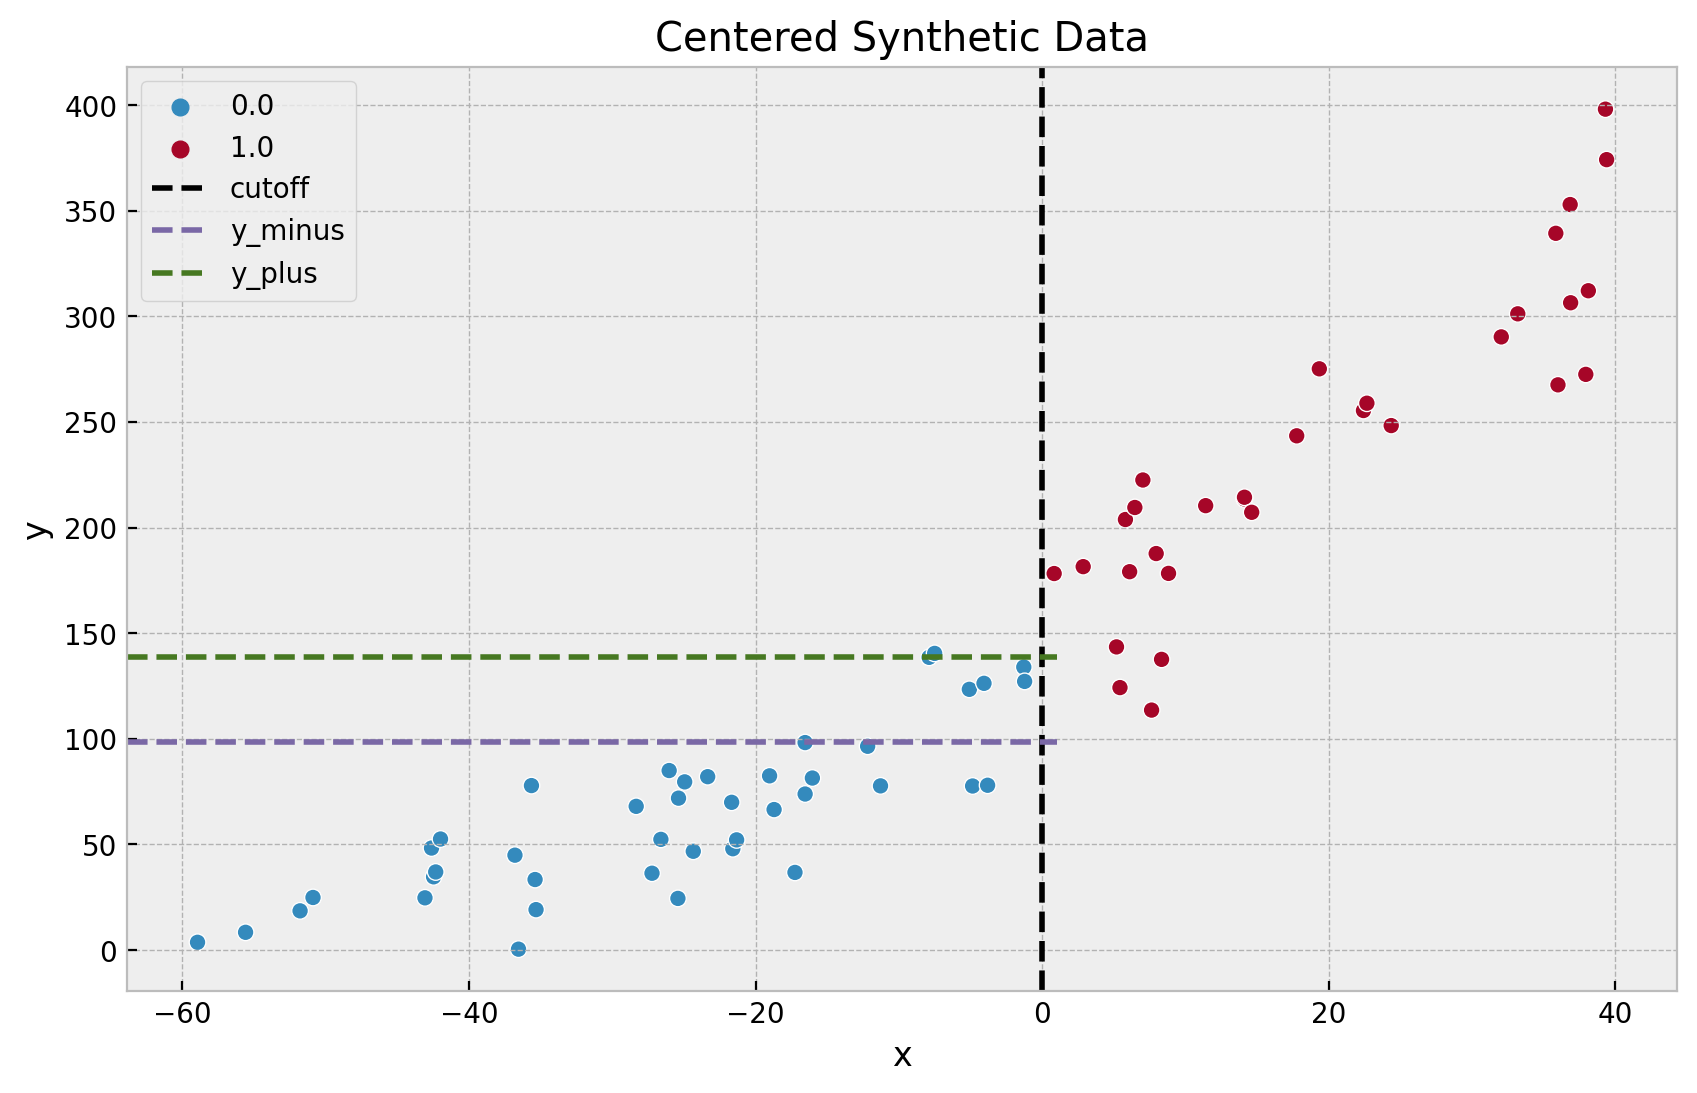

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", hue="d", ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
ax.axhline(
    y=y_minus,
    xmax=0.6,
    color="C2",
    linestyle="--",
    label="y_minus",
)
ax.axhline(
    y=y_plus,
    xmax=0.6,
    color="C3",
    linestyle="--",
    label="y_plus",
)
ax.legend(loc="upper left")
ax.set(title="Centered Synthetic Data", xlabel="x", ylabel="y")

Now we present three models to estimate the treatment effect: OLS, GLM and GLM with kernel weighting.

## Linear Regression (OLS)

Recall that the OLS estimator aims to fit straight lines for the pre and post intervention periods. The idea is to use a single model to achieve this. The strategy is well known: consider a linear model with an interaction term between the running variable $x$ and the treatment indicator $d$. Specifically, 

\begin{align*}
y & \sim \text{Normal}(\mu, \sigma) \\
\mu & = \beta_0 + \beta_1 x + \beta_2 d + \beta_3 x d
\end{align*}

Note that the intercept $\beta_2$ is precisely the treatment effect as we are assuming the cutoff is at zero.

Now that the strategy is clear, let's prepare the data.

In [7]:
obs_idx = data.index.to_numpy()
x_c = data["x_c"].to_numpy()
d = data["d"].to_numpy()
y = data["y"].to_numpy()


Now we specify the model in PyMC.

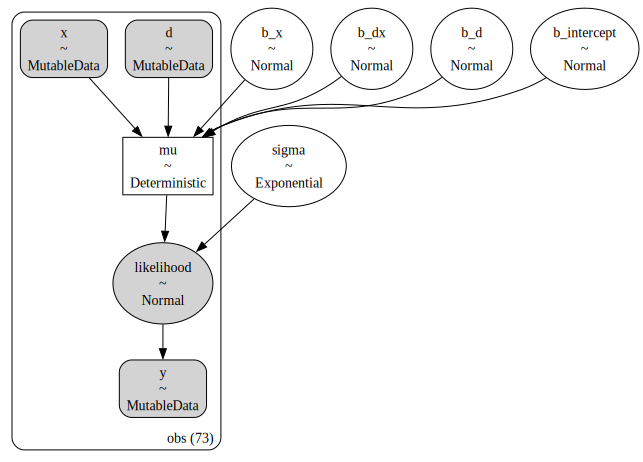

In [8]:
with pm.Model(coords={"obs": obs_idx}) as gaussian_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=120, sigma=50)
    b_x = pm.Normal(name="b_x", mu=0, sigma=4)
    b_d = pm.Normal(name="b_d", mu=0, sigma=50)
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=4)
    sigma = pm.Exponential(name="sigma", lam=1 / 50)
    # --- Deterministic Variables ---
    mu = pm.Deterministic(
        name="mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gaussian_model)


An fundamental component of the model(s) are the prior specifications. This is one of the key advantages of the bayesian approach! For this model, use non-informative priors for the parameters. We can verify this through prior predictive checks.

In [9]:
with gaussian_model:
    gaussian_prior_predictive = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )


Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


Let's visualize the prior predictive distribution.

[Text(0.5, 1.0, 'Linear Regression Model - Prior Predictive Distribution')]

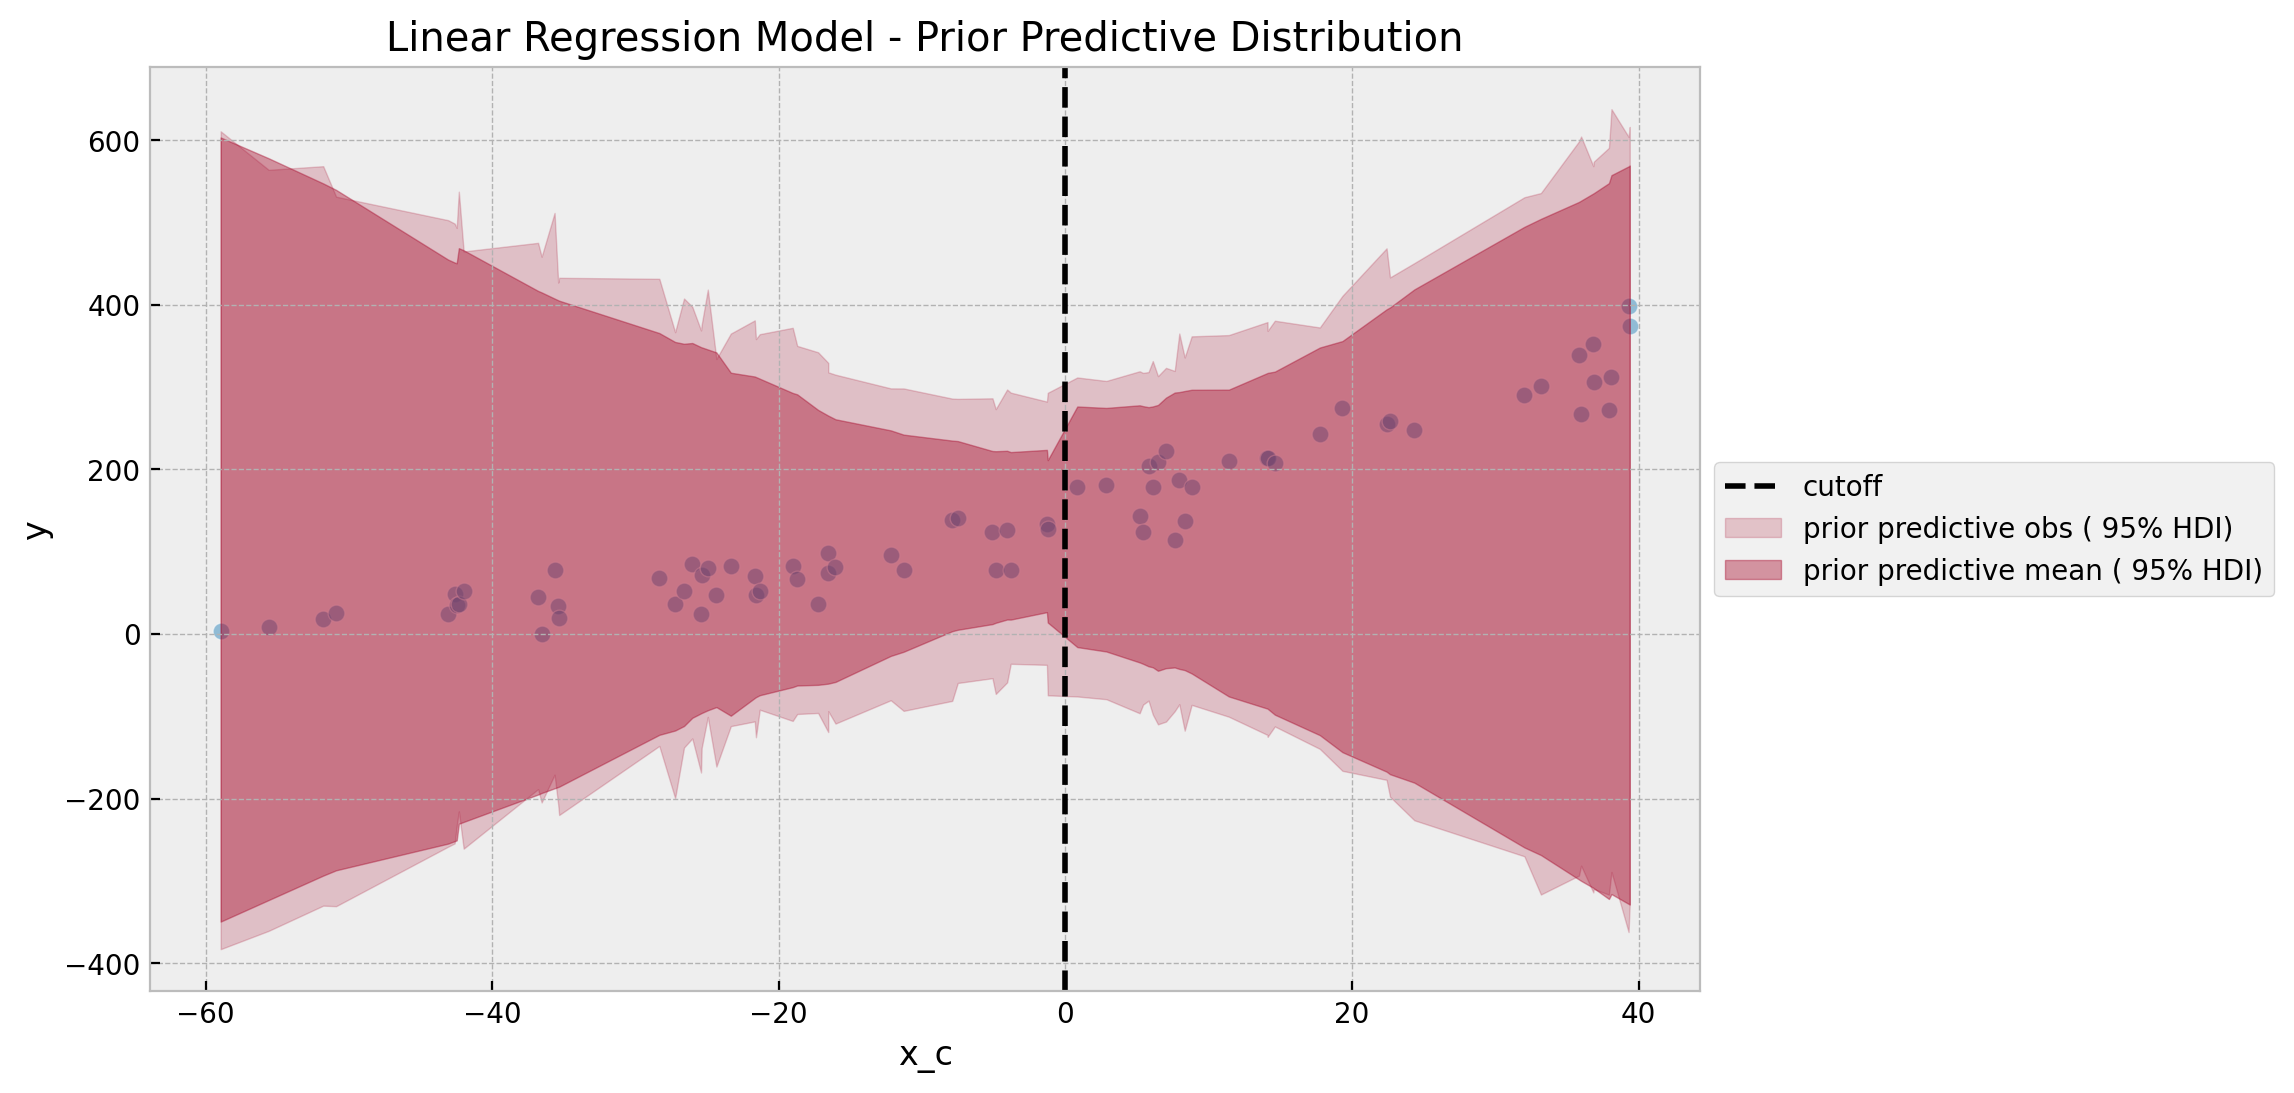

In [10]:
alpha = 0.05

fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gaussian_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gaussian_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Linear Regression Model - Prior Predictive Distribution")

Overall, it looks like a reasonable prior specification. Note however that the prior predictive distribution does allow for the negative values, which in view of the data context it makes no sense (so it should not be plausible!). This can not be fixed completely by constraining the priors as it is more of a fundamental consequence of the normal likelihood. We will see how to address this issue with the GLM approach below.

Next, we proceed to sample from the posterior distribution.

In [11]:
with gaussian_model:
    gaussian_idata = pm.sample(
        tune=2_000, draws=6_000, chains=5, nuts_sampler="numpyro", random_seed=rng
    )
    gaussian_posterior_predictive = pm.sample_posterior_predictive(
        trace=gaussian_idata, random_seed=rng
    )

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.933100
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:00:04.362230
Transforming variables...


Sampling: [likelihood]


Transformation time =  0:00:00.270326


We can now look into the diagnostics and resulting trace plots.

In [12]:
gaussian_idata["sample_stats"]["diverging"].sum().item()


0

In [13]:
az.summary(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept  116.365   7.863  101.937  131.648      0.072    0.051   12104.0   
b_x            2.033   0.267    1.553    2.555      0.002    0.002   12252.0   
b_d           28.270  11.335    7.427   49.845      0.092    0.065   15226.0   
b_dx           2.831   0.454    1.982    3.687      0.004    0.003   14803.0   
sigma         26.969   2.351   22.706   31.340      0.017    0.013   18936.0   

             ess_tail  r_hat  
b_intercept   14376.0    1.0  
b_x           15504.0    1.0  
b_d           17264.0    1.0  
b_dx          16801.0    1.0  
sigma         16808.0    1.0

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Linear Regression Model - Trace')

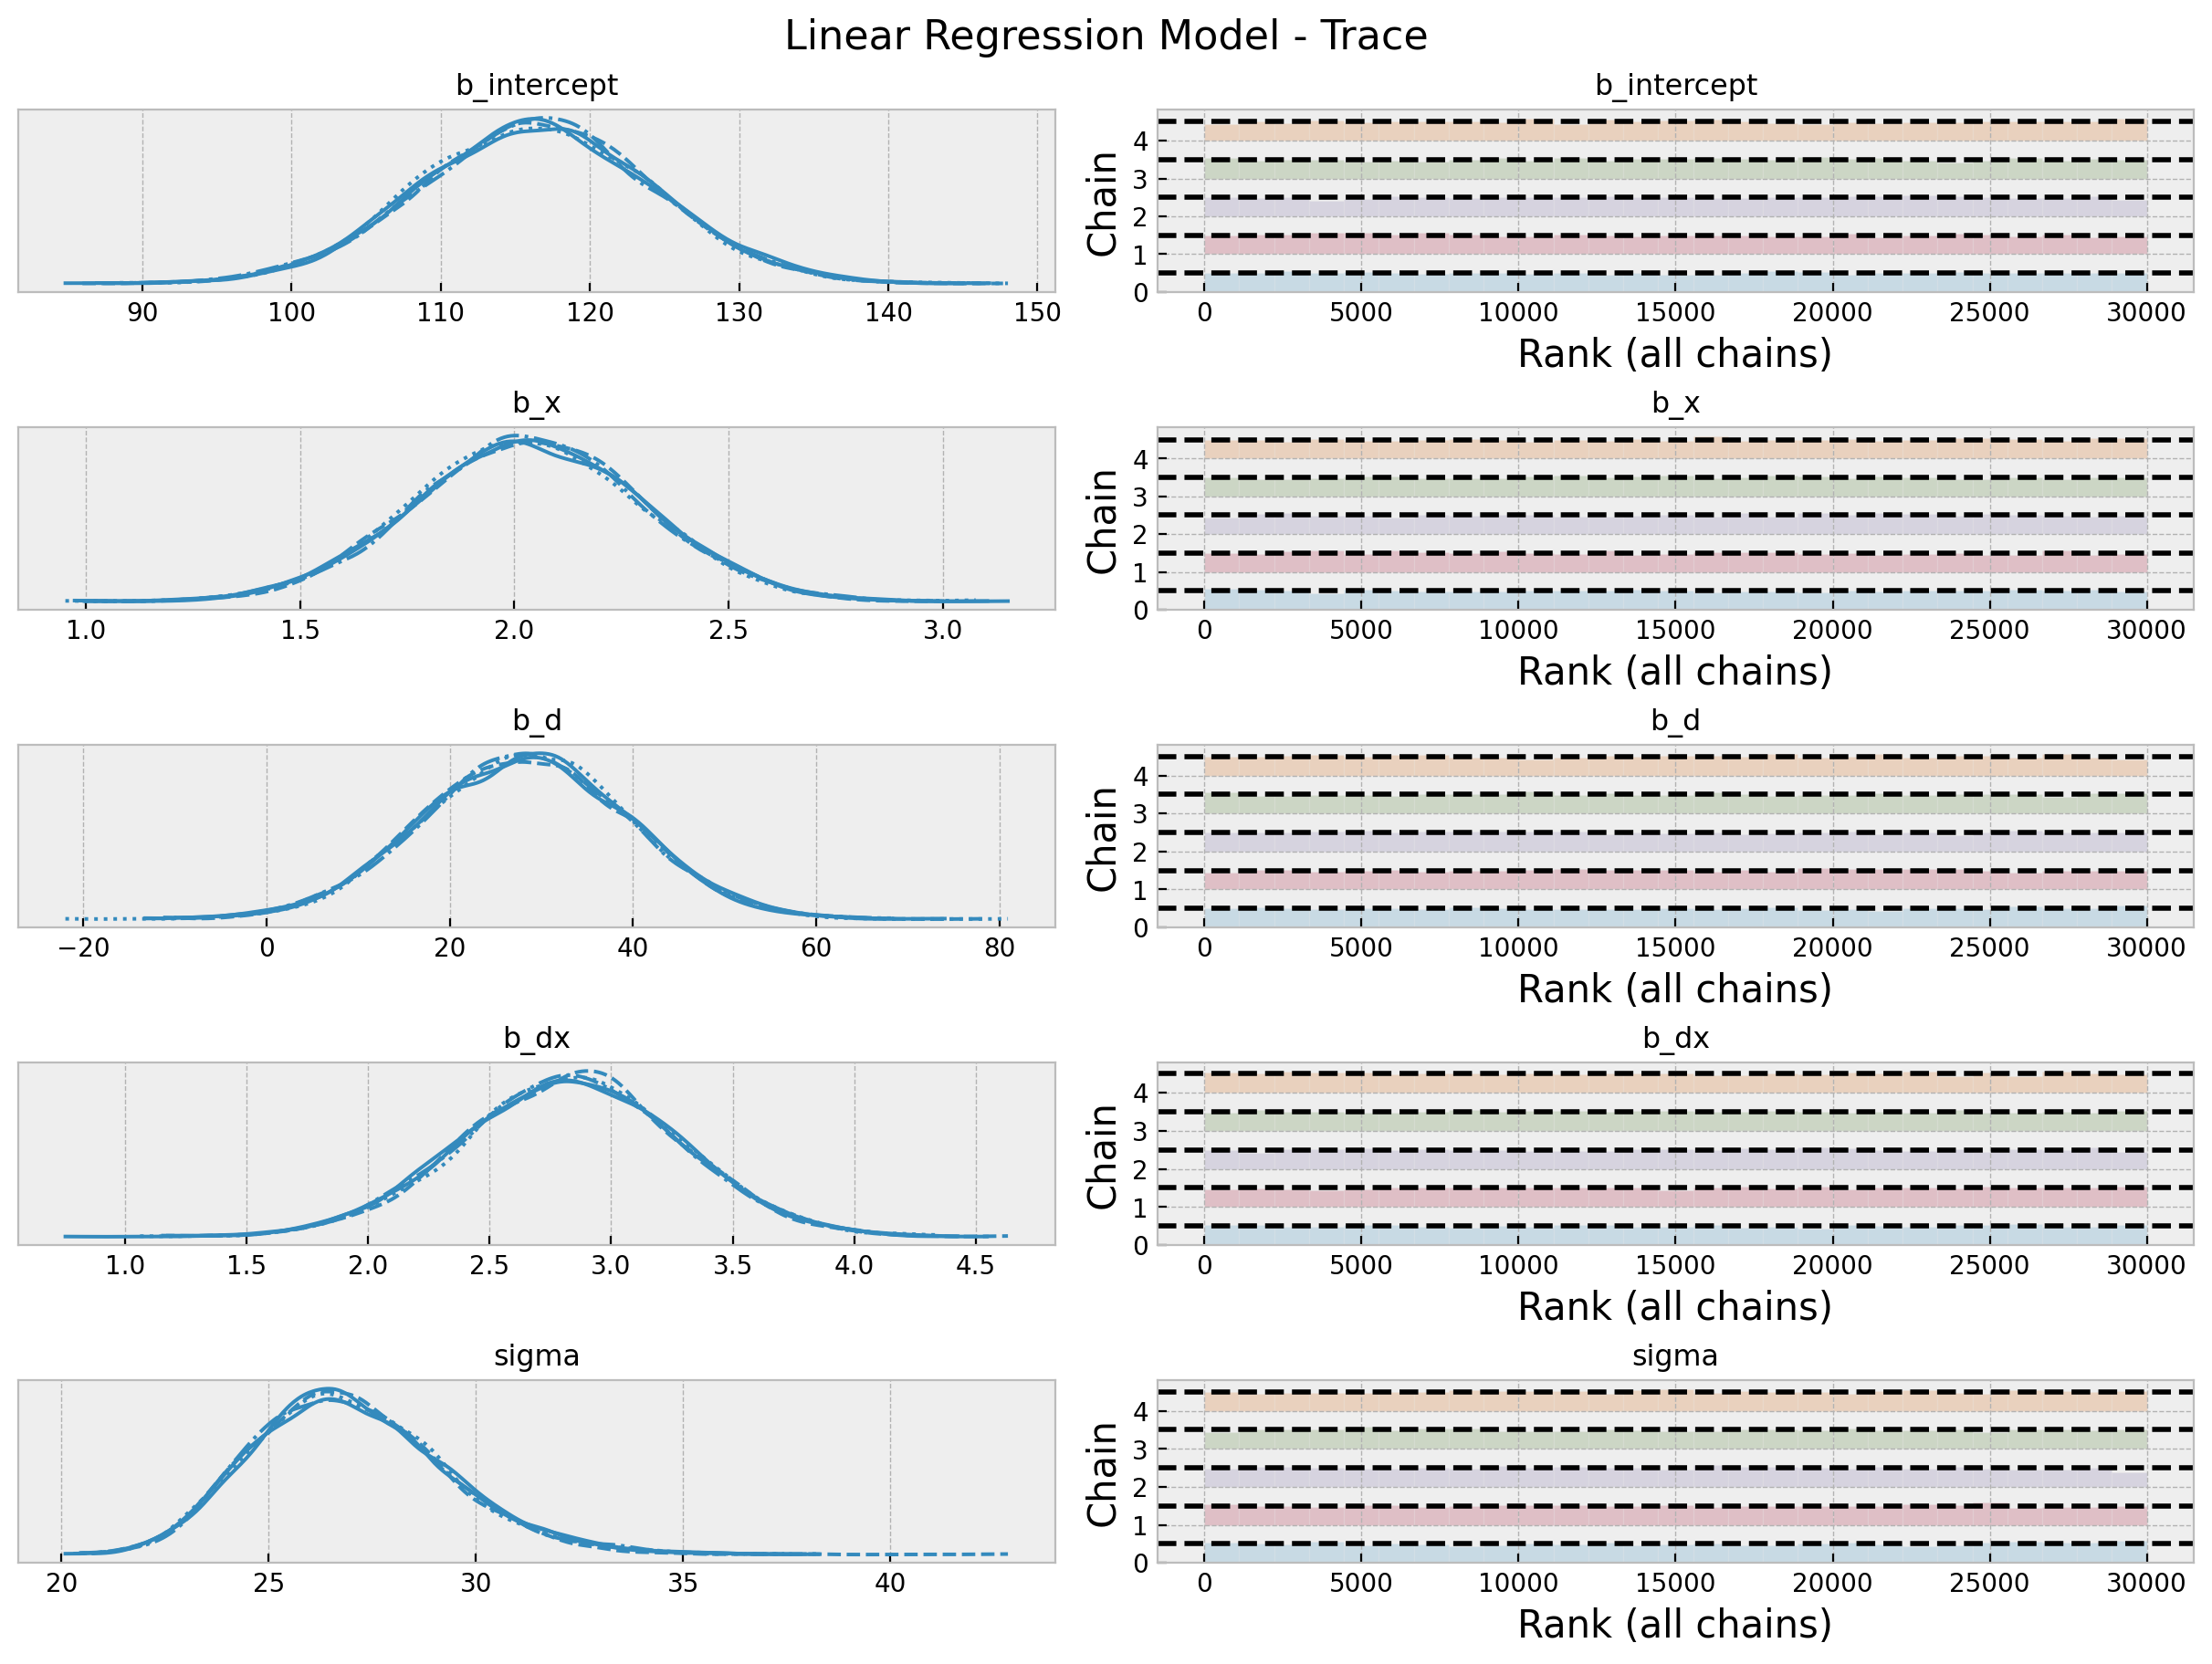

In [14]:
axes = az.plot_trace(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16)


Overall, the diagnostics look good. The parameter of interest, which encodes the discontinuity at the cutoff is `b_d`. The posterior predictive mean of the estimated treatment effect is $\sim 28.7$ (recall that the true value is $40$). 

Finally, we can visualize the posterior predictive distribution.

[Text(0.5, 1.0, 'Linear Regression Model')]

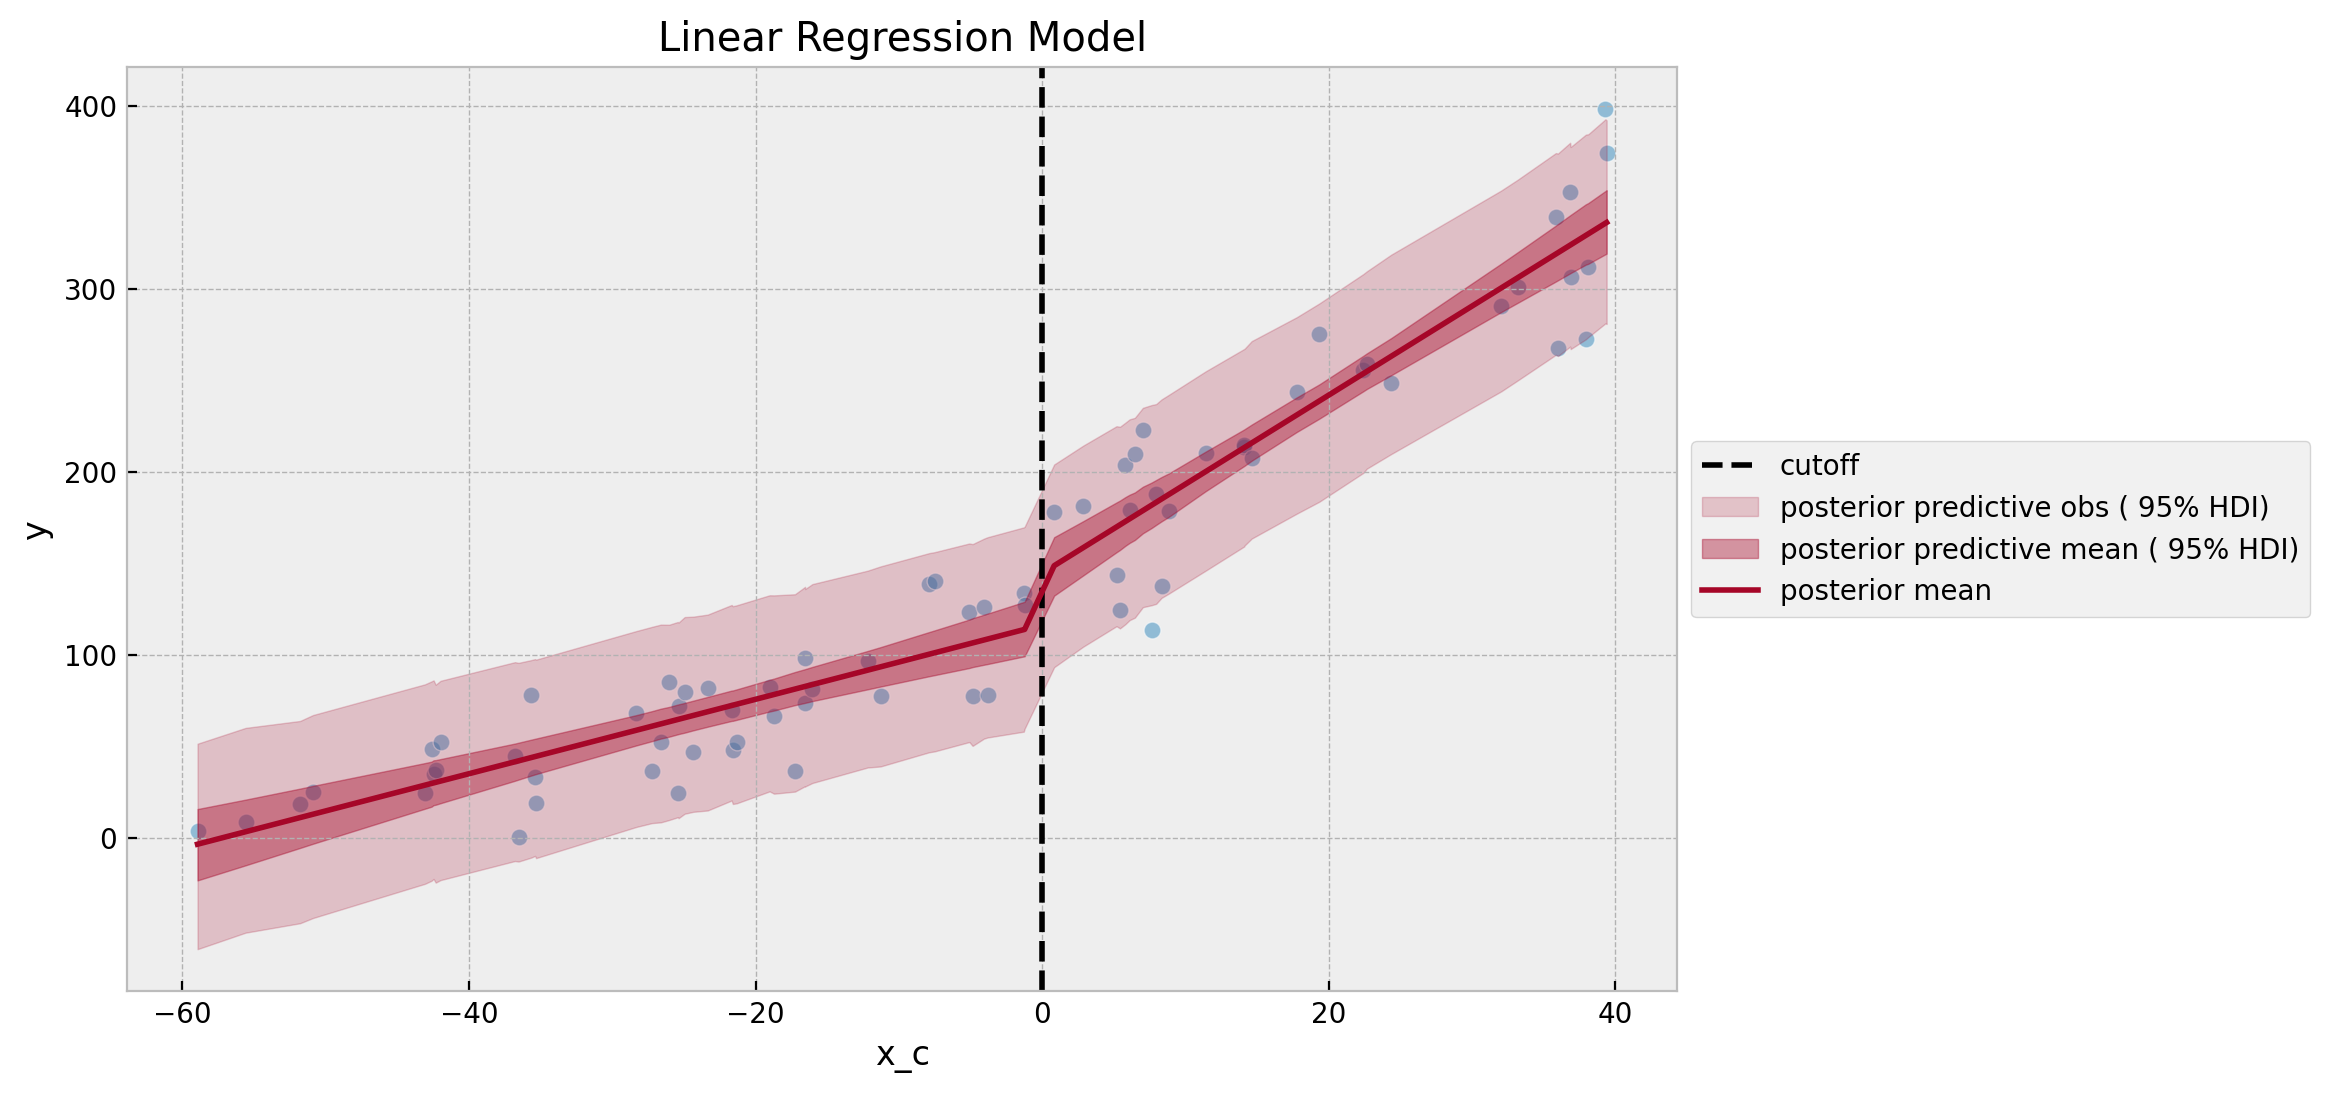

In [15]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gaussian_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gaussian_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gaussian_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Linear Regression Model")

Both  linear fits look quite reasonable. Still, the fact that the model predictions are not constrained to be non-negative is a bit annoying. We will see how to address this issue with the GLM approach below.

## Gamma Regression Model

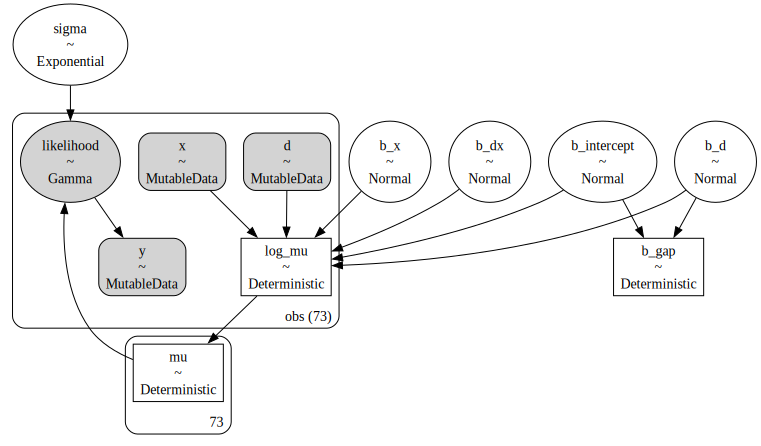

In [16]:
with pm.Model(coords={"obs": obs_idx}) as gamma_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=np.log(100), sigma=np.log(2))
    b_x = pm.Normal(name="b_x", mu=0, sigma=np.log(1 + 0.01))
    b_d = pm.Normal(name="b_d", mu=0, sigma=np.log(1.3))
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=np.log(1 + 0.01))
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    log_mu = pm.Deterministic(
        name="log_mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    mu = pm.Deterministic(name="mu", var=pm.math.exp(log_mu))
    pm.Deterministic(
        name="b_gap", var=pm.math.exp(b_intercept) * (pm.math.exp(b_d) - 1)
    )
    # --- Likelihood ---
    pm.Gamma(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gamma_model)


In [17]:
with gamma_model:
    gamma_prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)


Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Gamma Regression Model - Prior Predictive Distribution')]

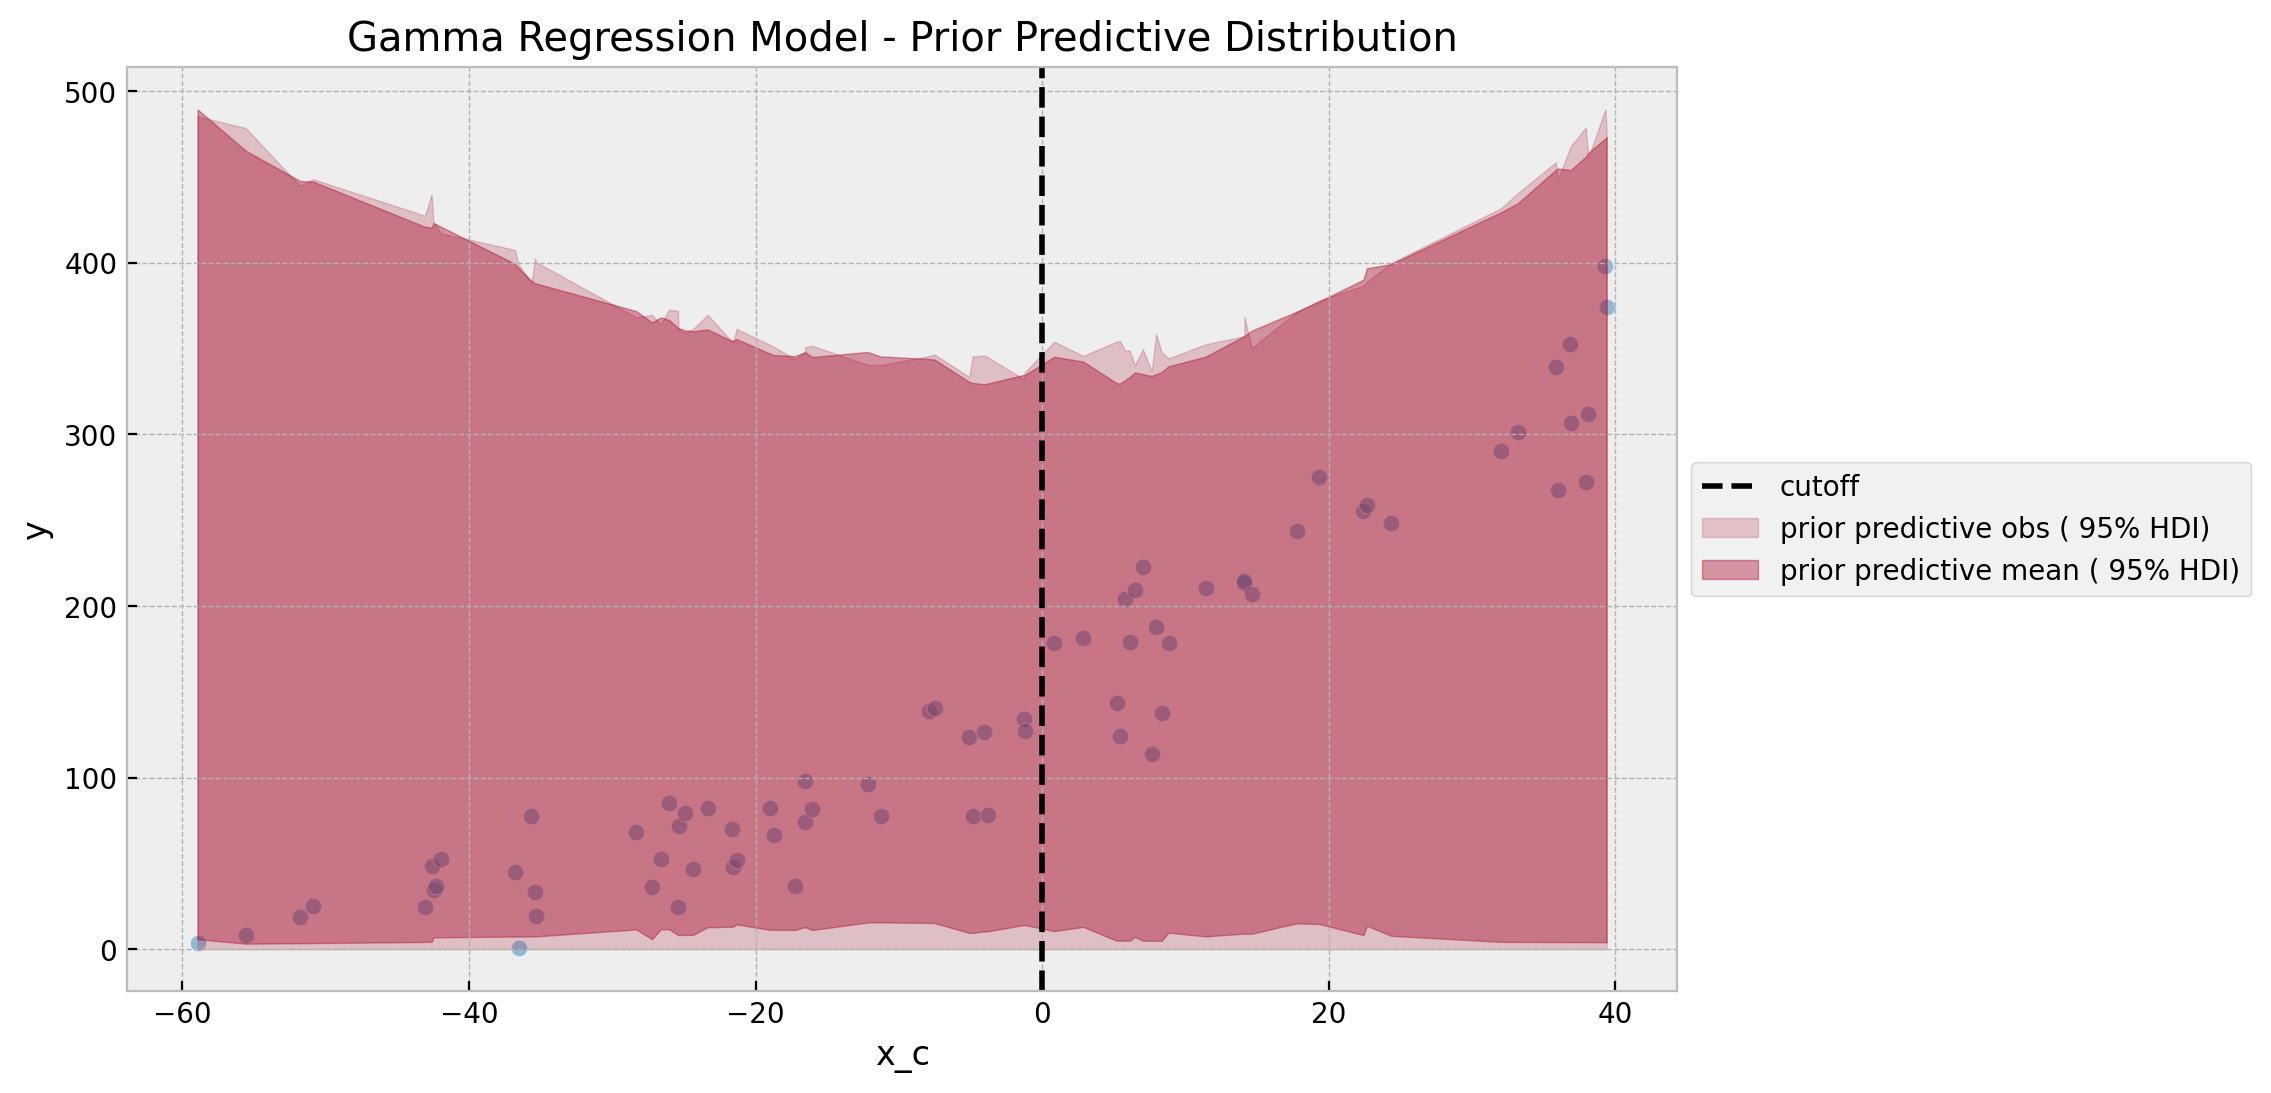

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gamma_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gamma_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model - Prior Predictive Distribution")

[Text(0.5, 1.0, 'Gamma Regression Model - Discontinuity Prior Predictive Distribution'),
 (-200.0, 200.0)]

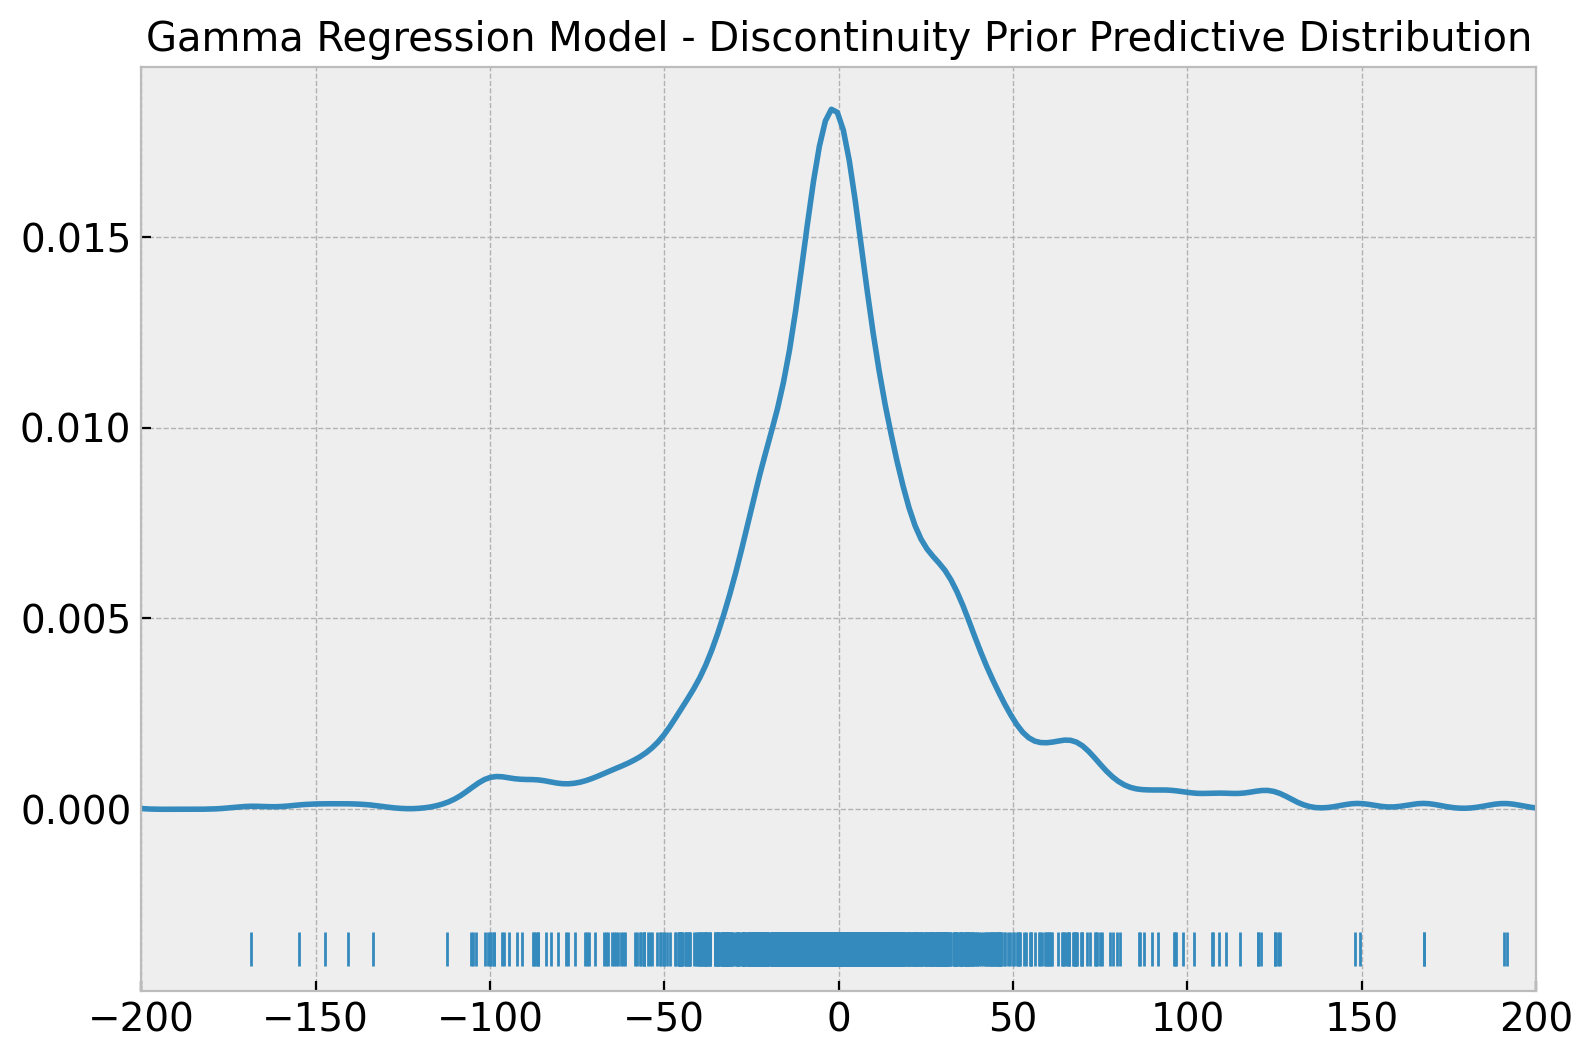

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))
az.plot_dist(
    values=az.extract(data=gamma_prior_predictive, group="prior", var_names=["b_gap"]),
    rug=True,
    ax=ax,
)
ax.set(
    title="Gamma Regression Model - Discontinuity Prior Predictive Distribution",
    xlim=(-2e2, 2e2),
)

In [20]:
with gamma_model:
    gamma_idata = pm.sample(
        tune=2_000, draws=6_000, chains=5, nuts_sampler="numpyro", random_seed=rng
    )
    gamma_posterior_predictive = pm.sample_posterior_predictive(
        trace=gamma_idata, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.551551
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:00:07.989736
Transforming variables...
Transformation time =  0:00:00.185837


Sampling: [likelihood]


In [21]:
gamma_idata["sample_stats"]["diverging"].sum().item()


0

In [22]:
az.summary(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept   4.824   0.084   4.658    4.975      0.001    0.001    8401.0   
b_x           0.027   0.003   0.020    0.033      0.000    0.000    8274.0   
b_d           0.218   0.097   0.034    0.397      0.001    0.001    9226.0   
b_dx         -0.006   0.004  -0.014    0.001      0.000    0.000    9366.0   
sigma        31.377   3.045  25.726   36.989      0.027    0.020   12790.0   
b_gap        30.032  12.834   5.291   53.560      0.129    0.093    9825.0   

             ess_tail  r_hat  
b_intercept   10690.0    1.0  
b_x           10624.0    1.0  
b_d           12375.0    1.0  
b_dx          11684.0    1.0  
sigma         14038.0    1.0  
b_gap         14407.0    1.0

Text(0.5, 0.98, 'Gamma Regression Model - Trace')

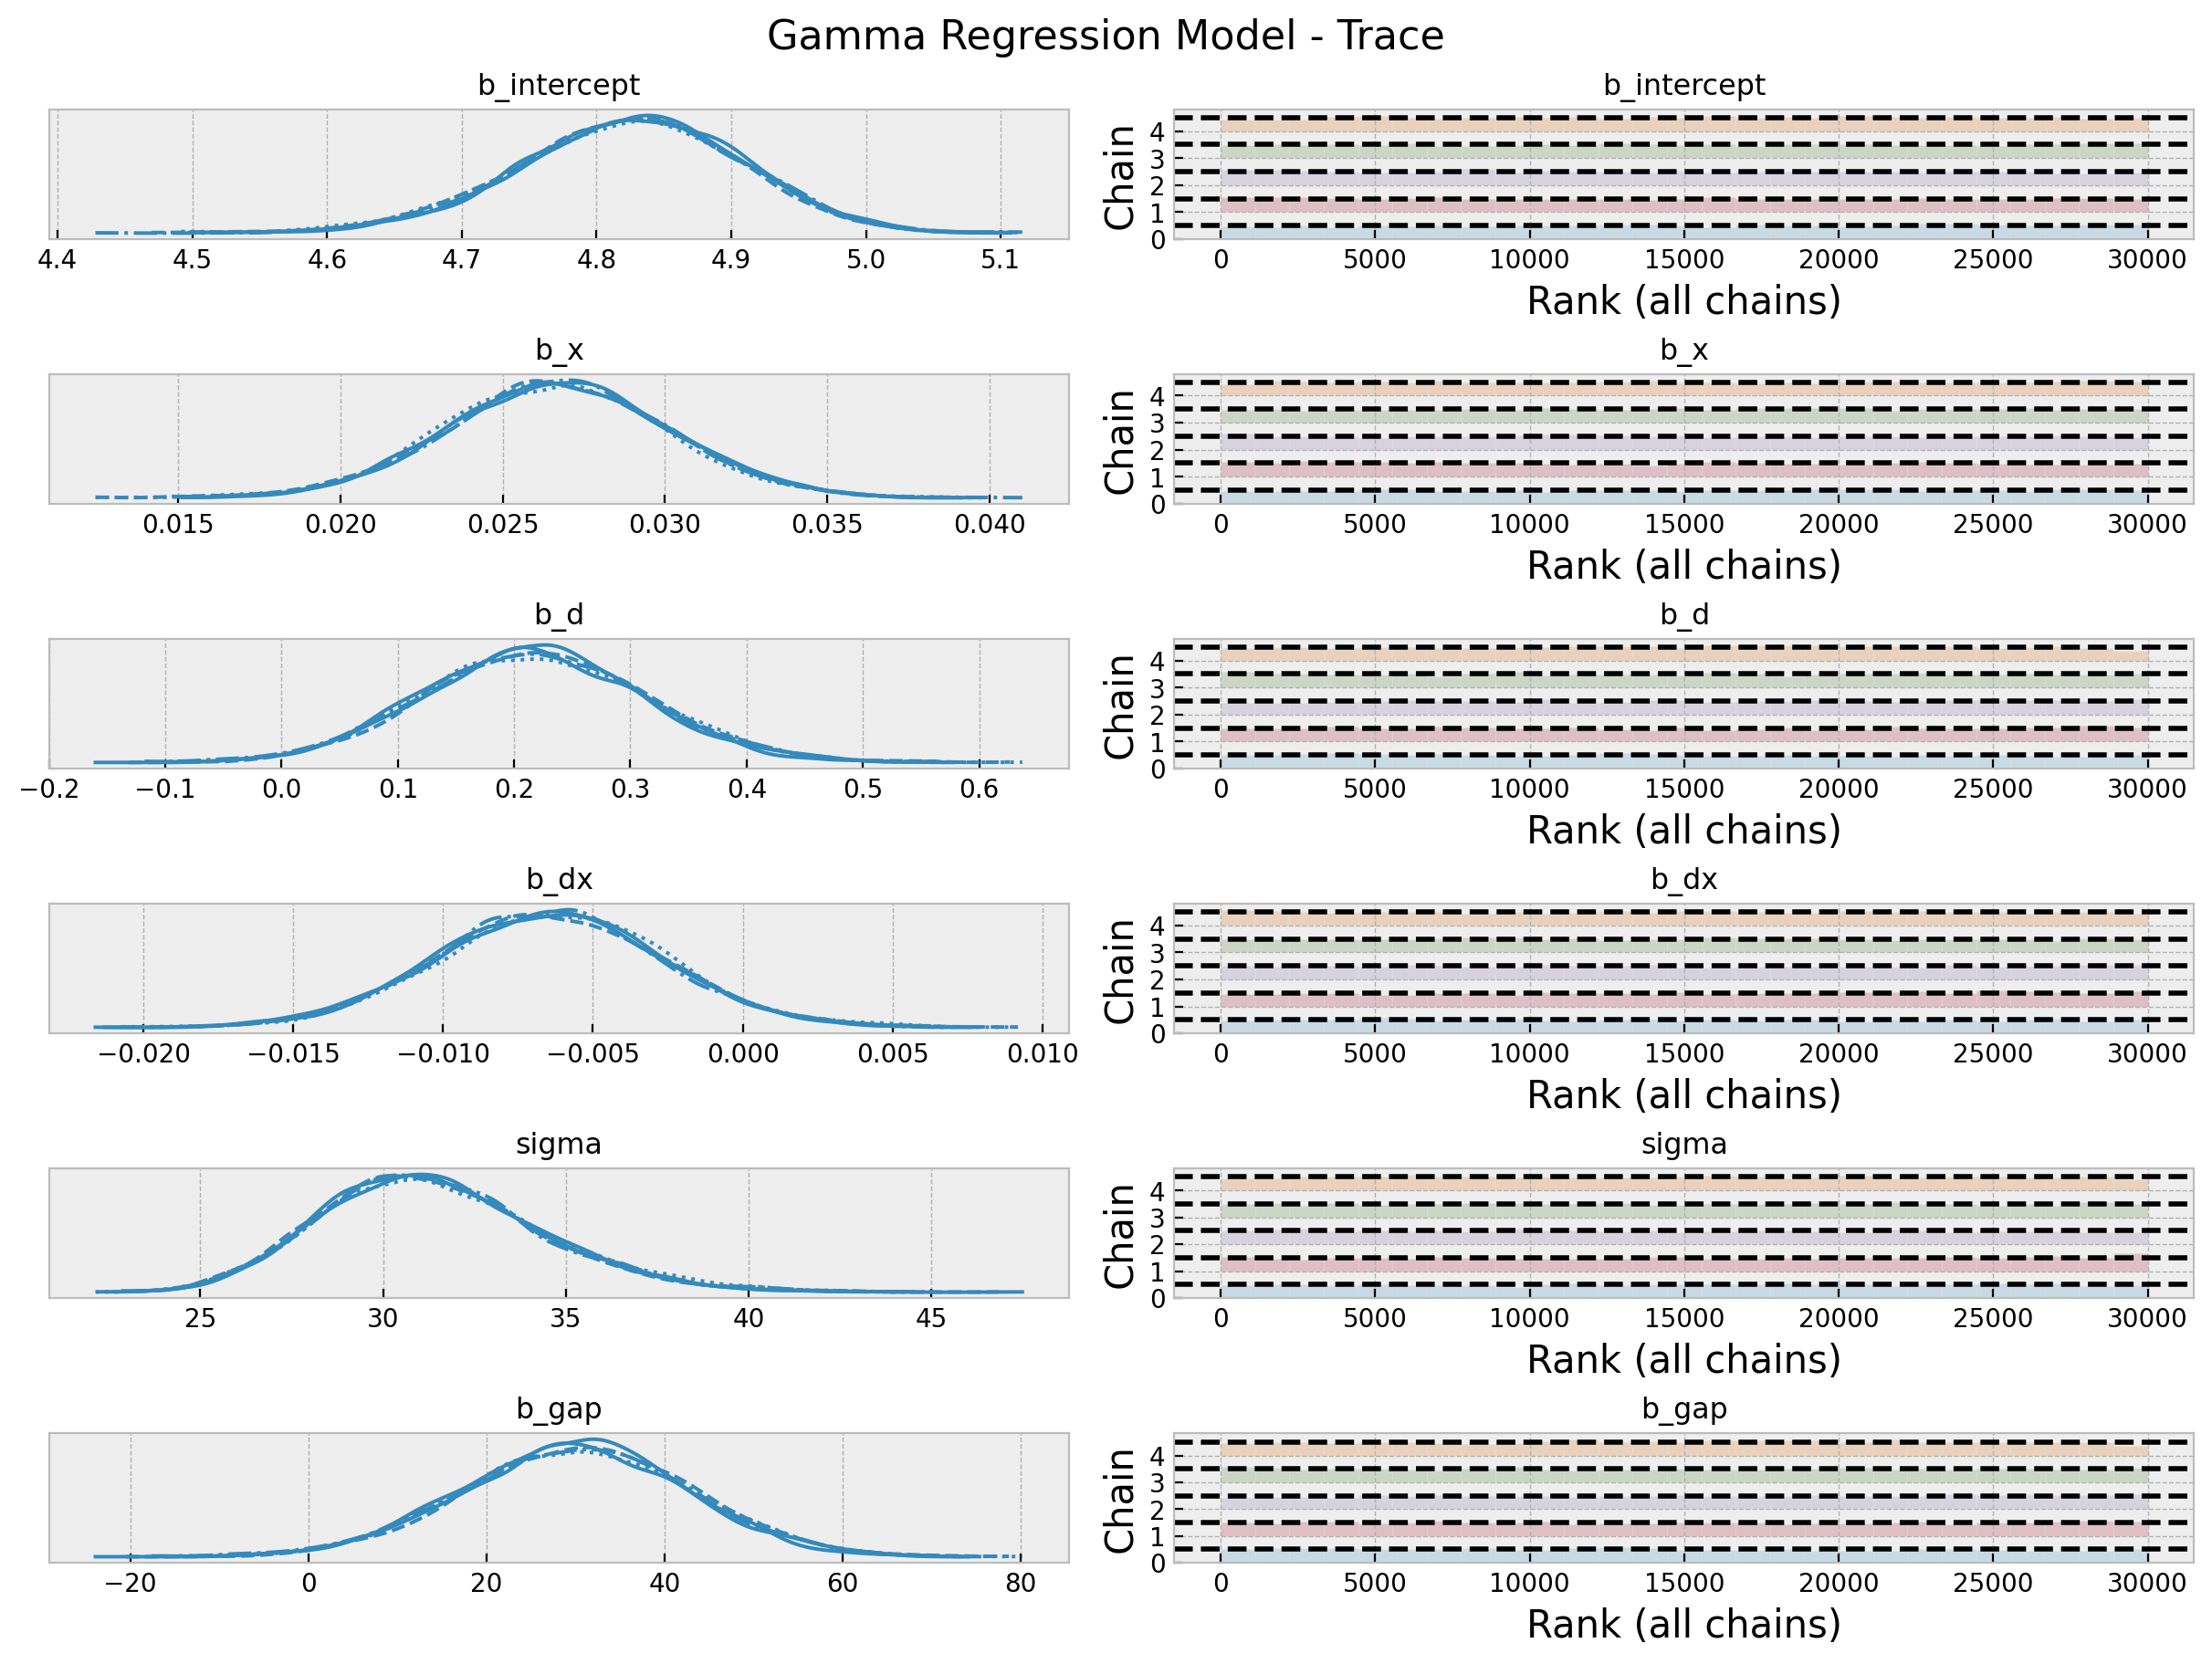

In [23]:
axes = az.plot_trace(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Regression Model - Trace", fontsize=16)


[Text(0.5, 1.0, 'Gamma Regression Model')]

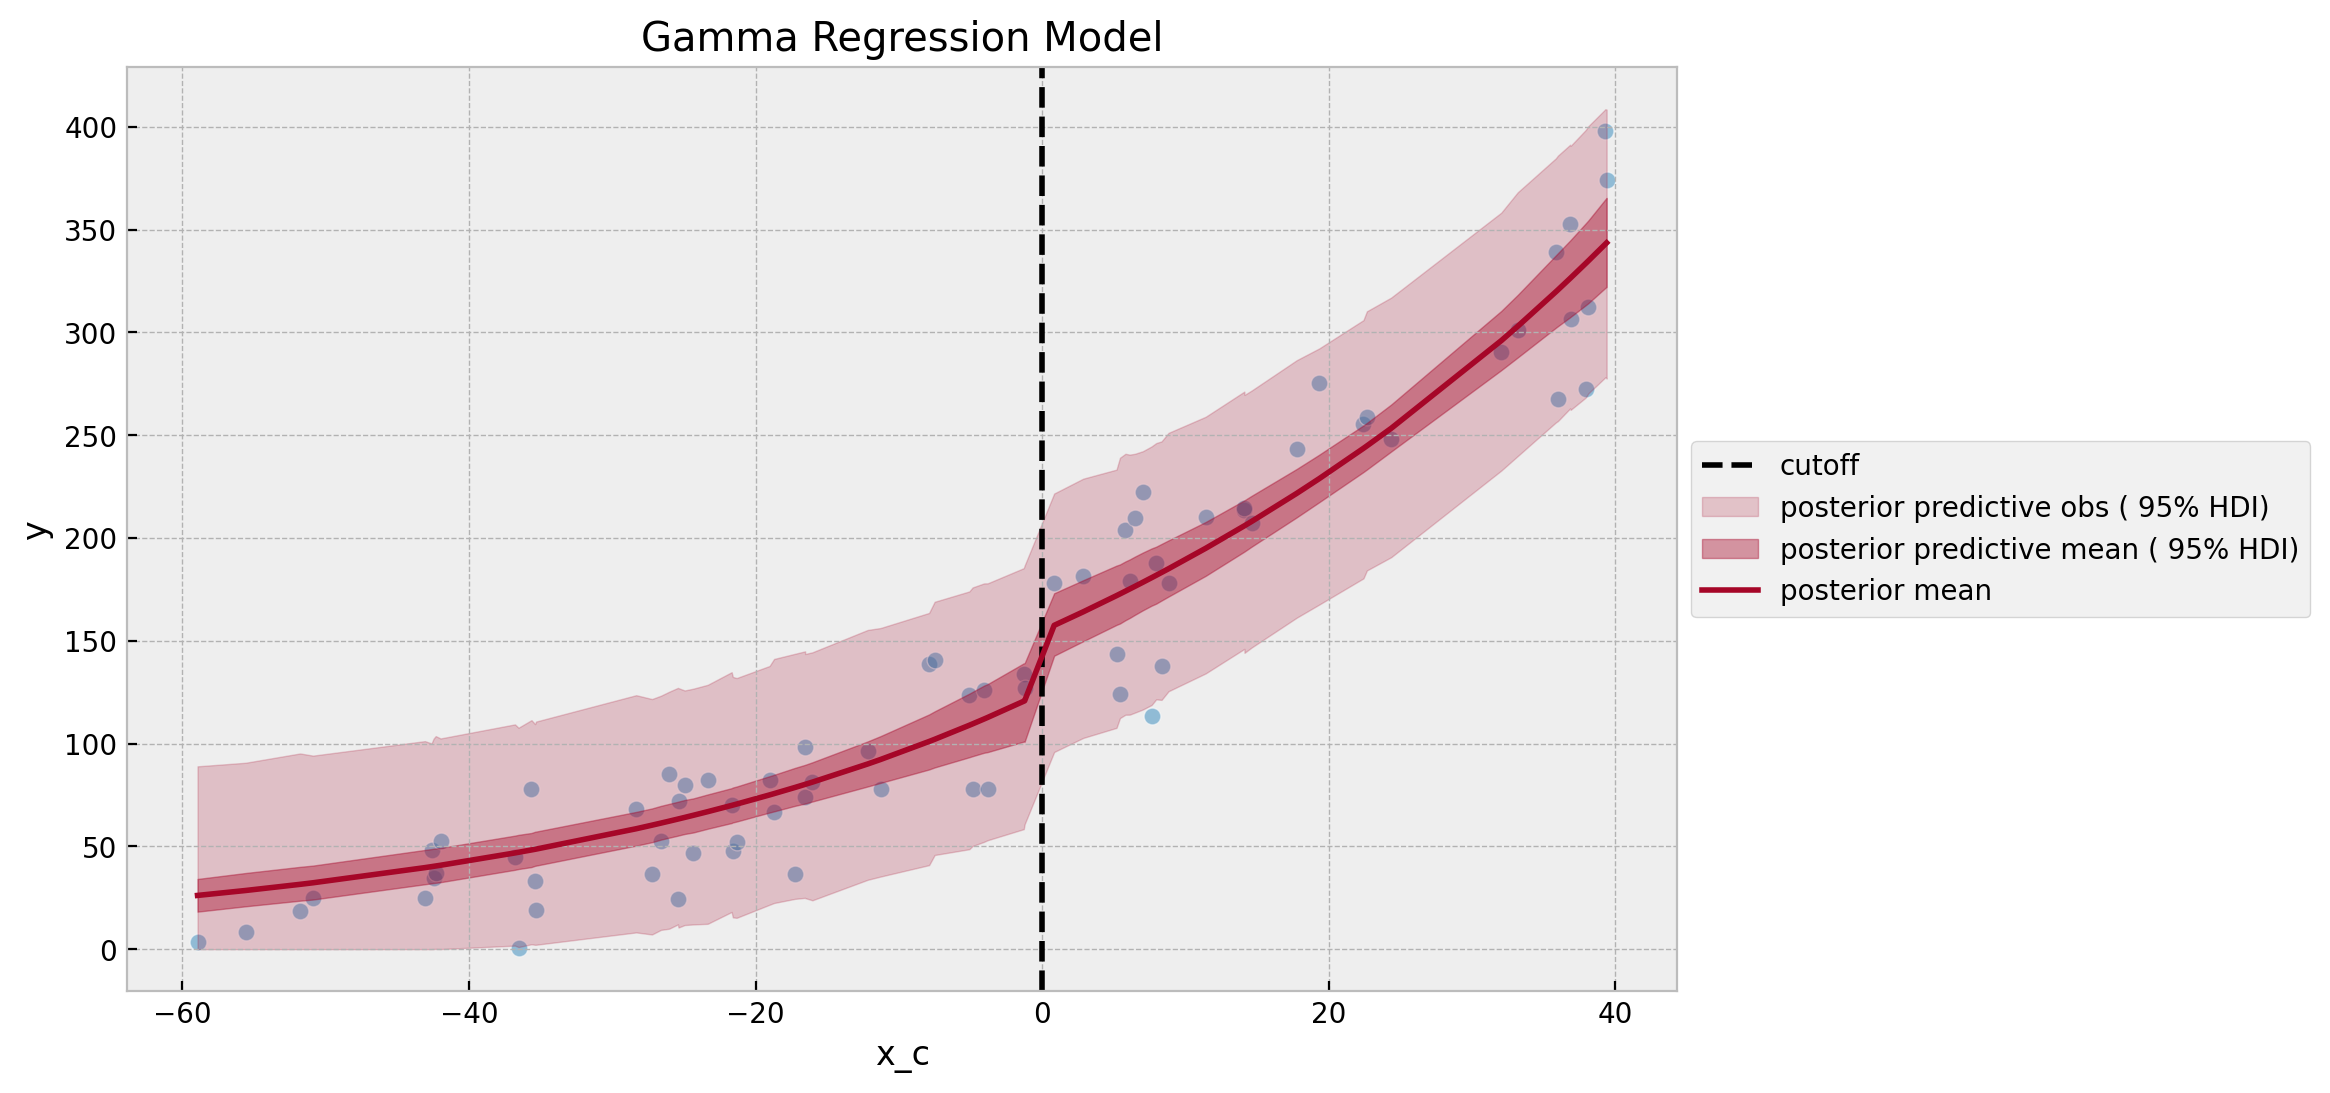

In [24]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gamma_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gamma_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gamma_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model")

[Text(0.5, 1.0, 'Kernel Function'),
 Text(0.5, 0, 'time centered'),
 Text(0, 0.5, 'kernel value')]

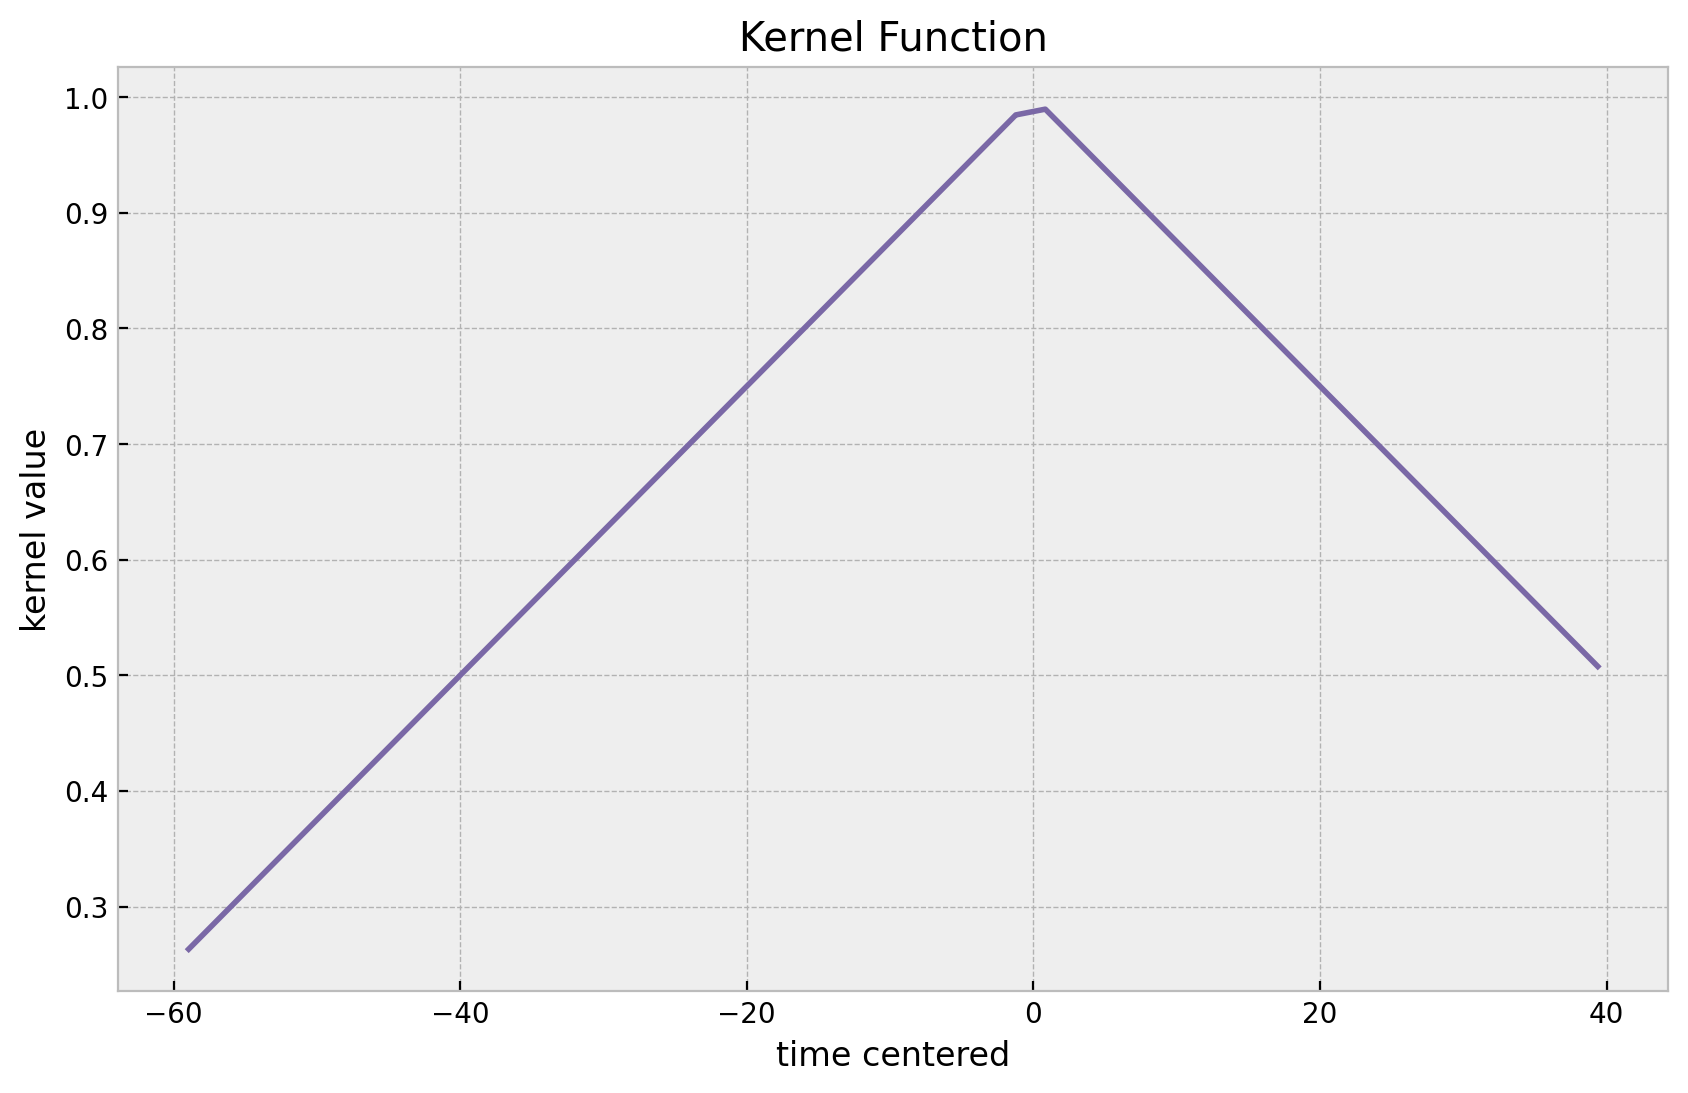

In [25]:
def kernel(r, c, h):
    indicator = (np.abs(r - c) <= h).astype(float)
    return indicator * (1 - np.abs(r - c) / h)


data["kernel"] = kernel(r=data["x_c"], c=0, h=80)
kernel = data["kernel"].to_numpy()

fig, ax = plt.subplots()
sns.lineplot(data=data, x="x_c", y="kernel", color="C2", ax=ax)
ax.set(title="Kernel Function", xlabel="time centered", ylabel="kernel value")


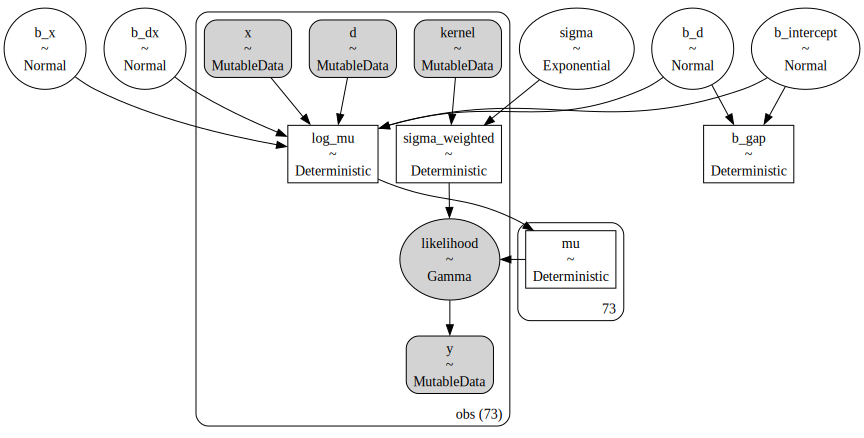

In [26]:
with pm.Model(coords={"obs": obs_idx}) as weighted_gamma_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    kernel_ = pm.MutableData(name="kernel", value=kernel, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=np.log(100), sigma=np.log(2))
    b_x = pm.Normal(name="b_x", mu=0, sigma=np.log(1 + 0.01))
    b_d = pm.Normal(name="b_d", mu=0, sigma=np.log(1.3))
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=np.log(1 + 0.01))
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    log_mu = pm.Deterministic(
        name="log_mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    mu = pm.Deterministic(name="mu", var=pm.math.exp(log_mu))
    pm.Deterministic(
        name="b_gap", var=pm.math.exp(b_intercept) * (pm.math.exp(b_d) - 1)
    )
    eps = np.finfo(float).eps
    sigma_weighted = pm.Deterministic(
        name="sigma_weighted", var=sigma / (kernel_ + eps), dims="obs"
    )
    # --- Likelihood ---
    pm.Gamma(
        name="likelihood",
        mu=mu,
        sigma=sigma_weighted,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=weighted_gamma_model)


In [27]:
with weighted_gamma_model:
    weighted_gamma_prior_predictive = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )


Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Weighted Gamma Regression Model - Prior Predictive Distribution')]

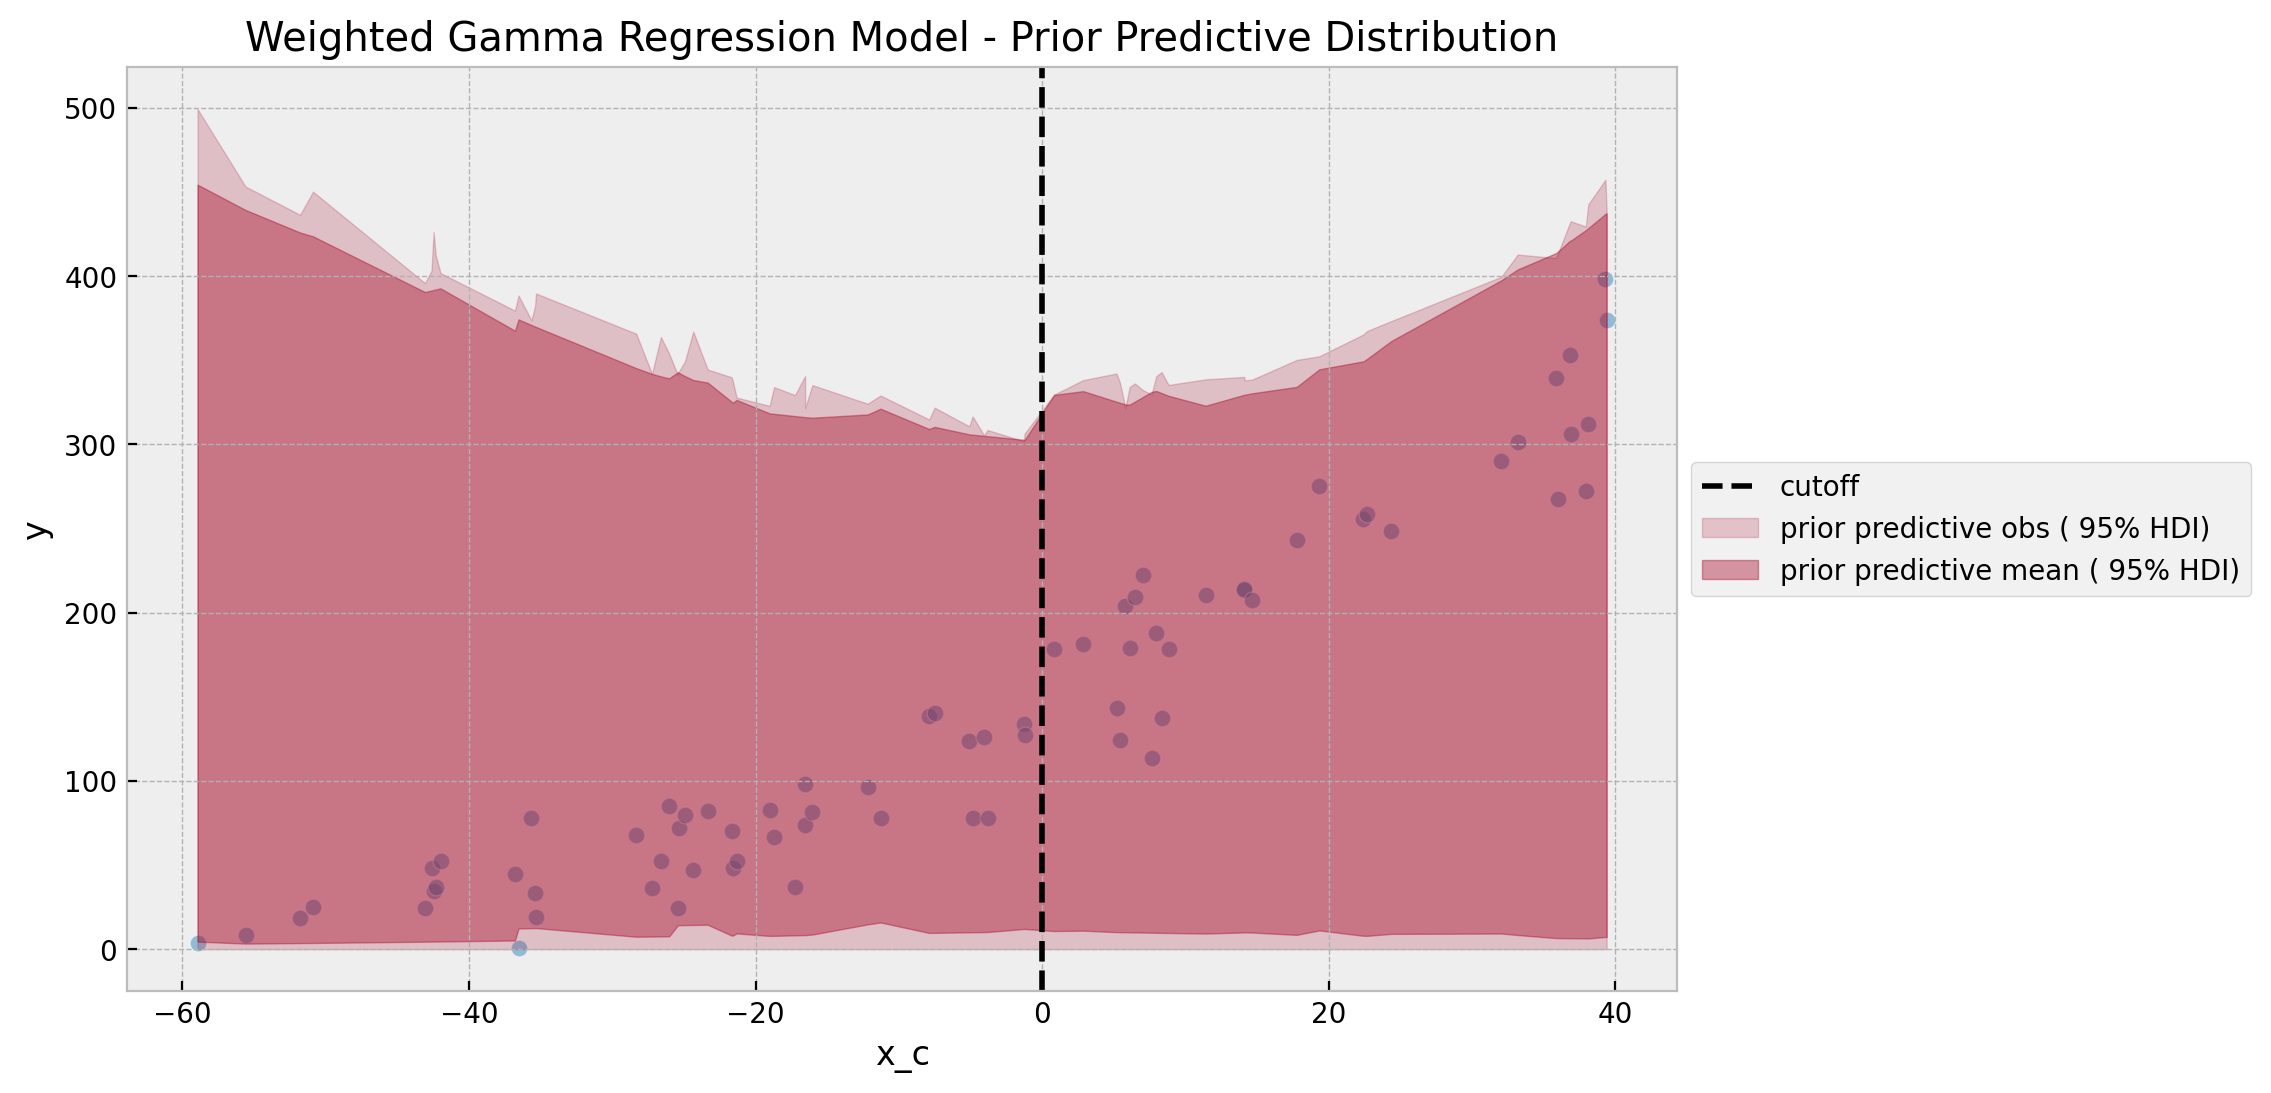

In [28]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    weighted_gamma_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    weighted_gamma_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Weighted Gamma Regression Model - Prior Predictive Distribution")

[Text(0.5, 1.0, 'Weighted Gamma Regression Model - Discontinuity Prior Predictive Distribution'),
 (-200.0, 200.0)]

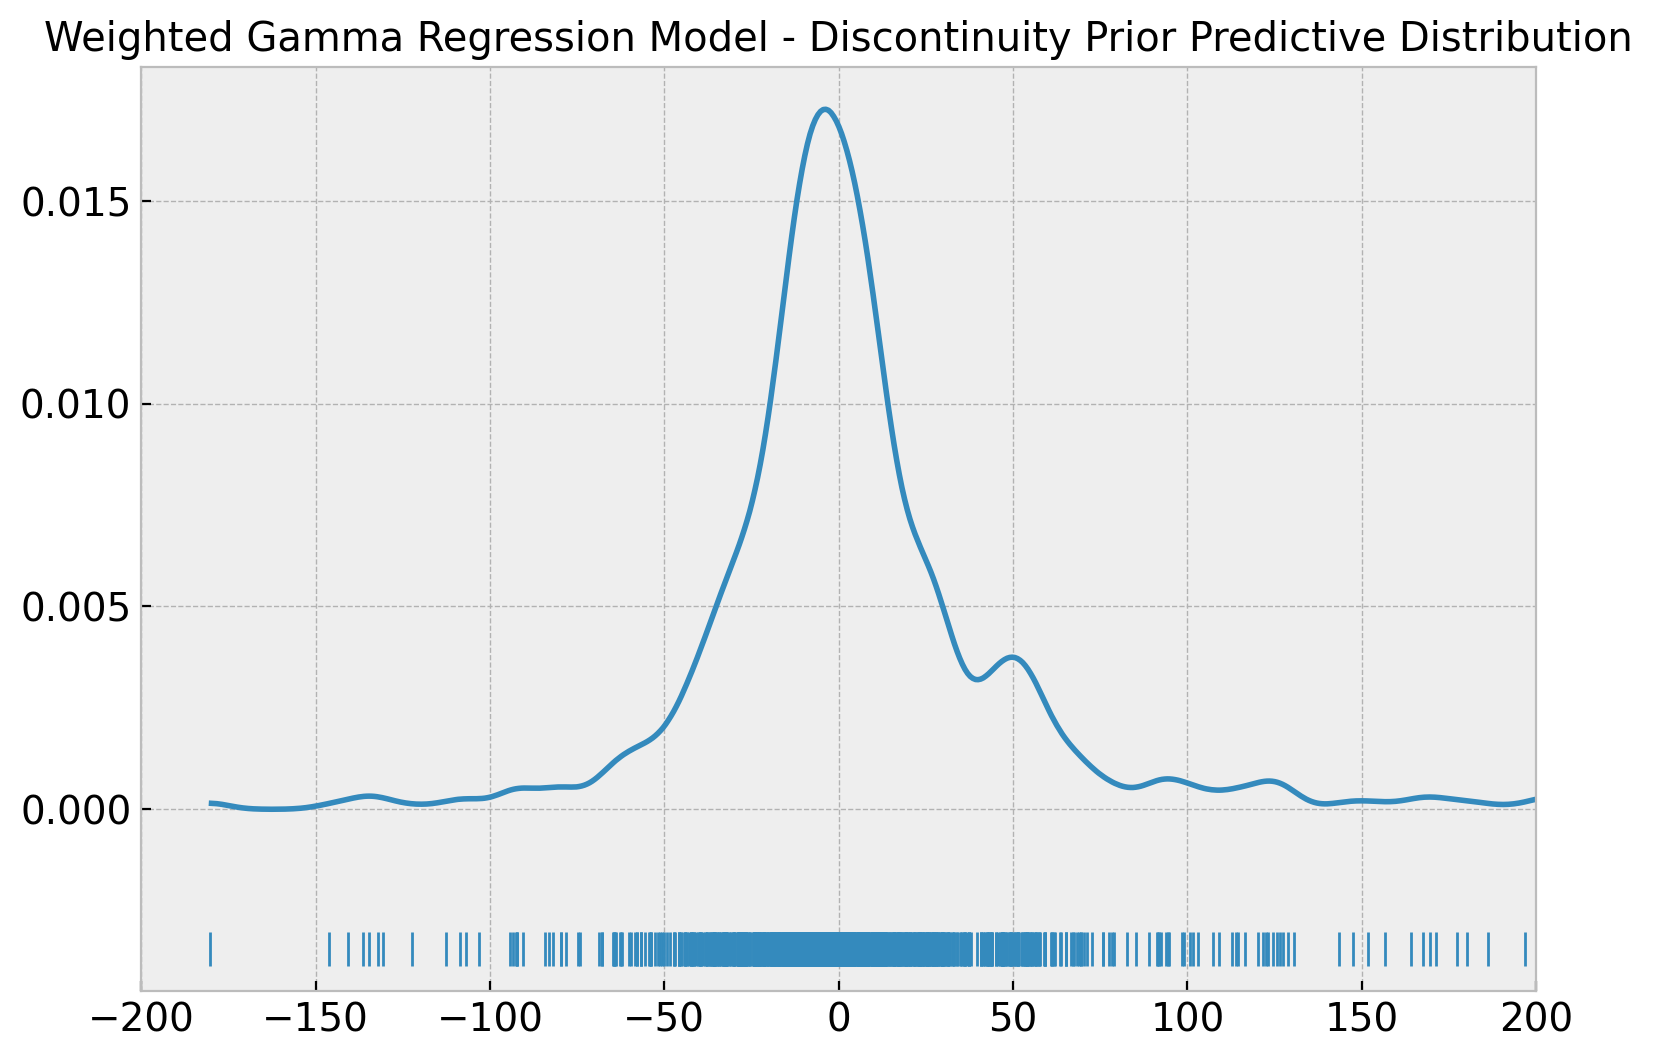

In [29]:
fig, ax = plt.subplots(figsize=(9, 6))
az.plot_dist(
    values=az.extract(
        data=weighted_gamma_prior_predictive, group="prior", var_names=["b_gap"]
    ),
    rug=True,
    ax=ax,
)
ax.set(
    title="Weighted Gamma Regression Model - Discontinuity Prior Predictive Distribution",
    xlim=(-2e2, 2e2),
)


In [30]:
with weighted_gamma_model:
    weighted_gamma_idata = pm.sample(
        tune=2_000, draws=6_000, chains=5, nuts_sampler="numpyro", random_seed=rng
    )
    weighted_gamma_posterior_predictive = pm.sample_posterior_predictive(
        trace=weighted_gamma_idata, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.704511
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:00:07.233943
Transforming variables...
Transformation time =  0:00:00.182223


Sampling: [likelihood]


In [31]:
weighted_gamma_idata["sample_stats"]["diverging"].sum().item()


0

In [32]:
az.summary(
    data=weighted_gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept   4.778   0.076   4.633    4.916      0.001    0.001    9203.0   
b_x           0.021   0.004   0.014    0.027      0.000    0.000    9273.0   
b_d           0.251   0.087   0.091    0.417      0.001    0.001    9825.0   
b_dx          0.000   0.004  -0.007    0.008      0.000    0.000   10294.0   
sigma        23.728   2.339  19.428   28.125      0.021    0.015   13226.0   
b_gap        33.754  11.157  12.670   54.397      0.109    0.077   10531.0   

             ess_tail  r_hat  
b_intercept   10397.0    1.0  
b_x           12013.0    1.0  
b_d           12288.0    1.0  
b_dx          12183.0    1.0  
sigma         14665.0    1.0  
b_gap         13790.0    1.0

Text(0.5, 0.98, 'Weighted Gamma Regression Model - Trace')

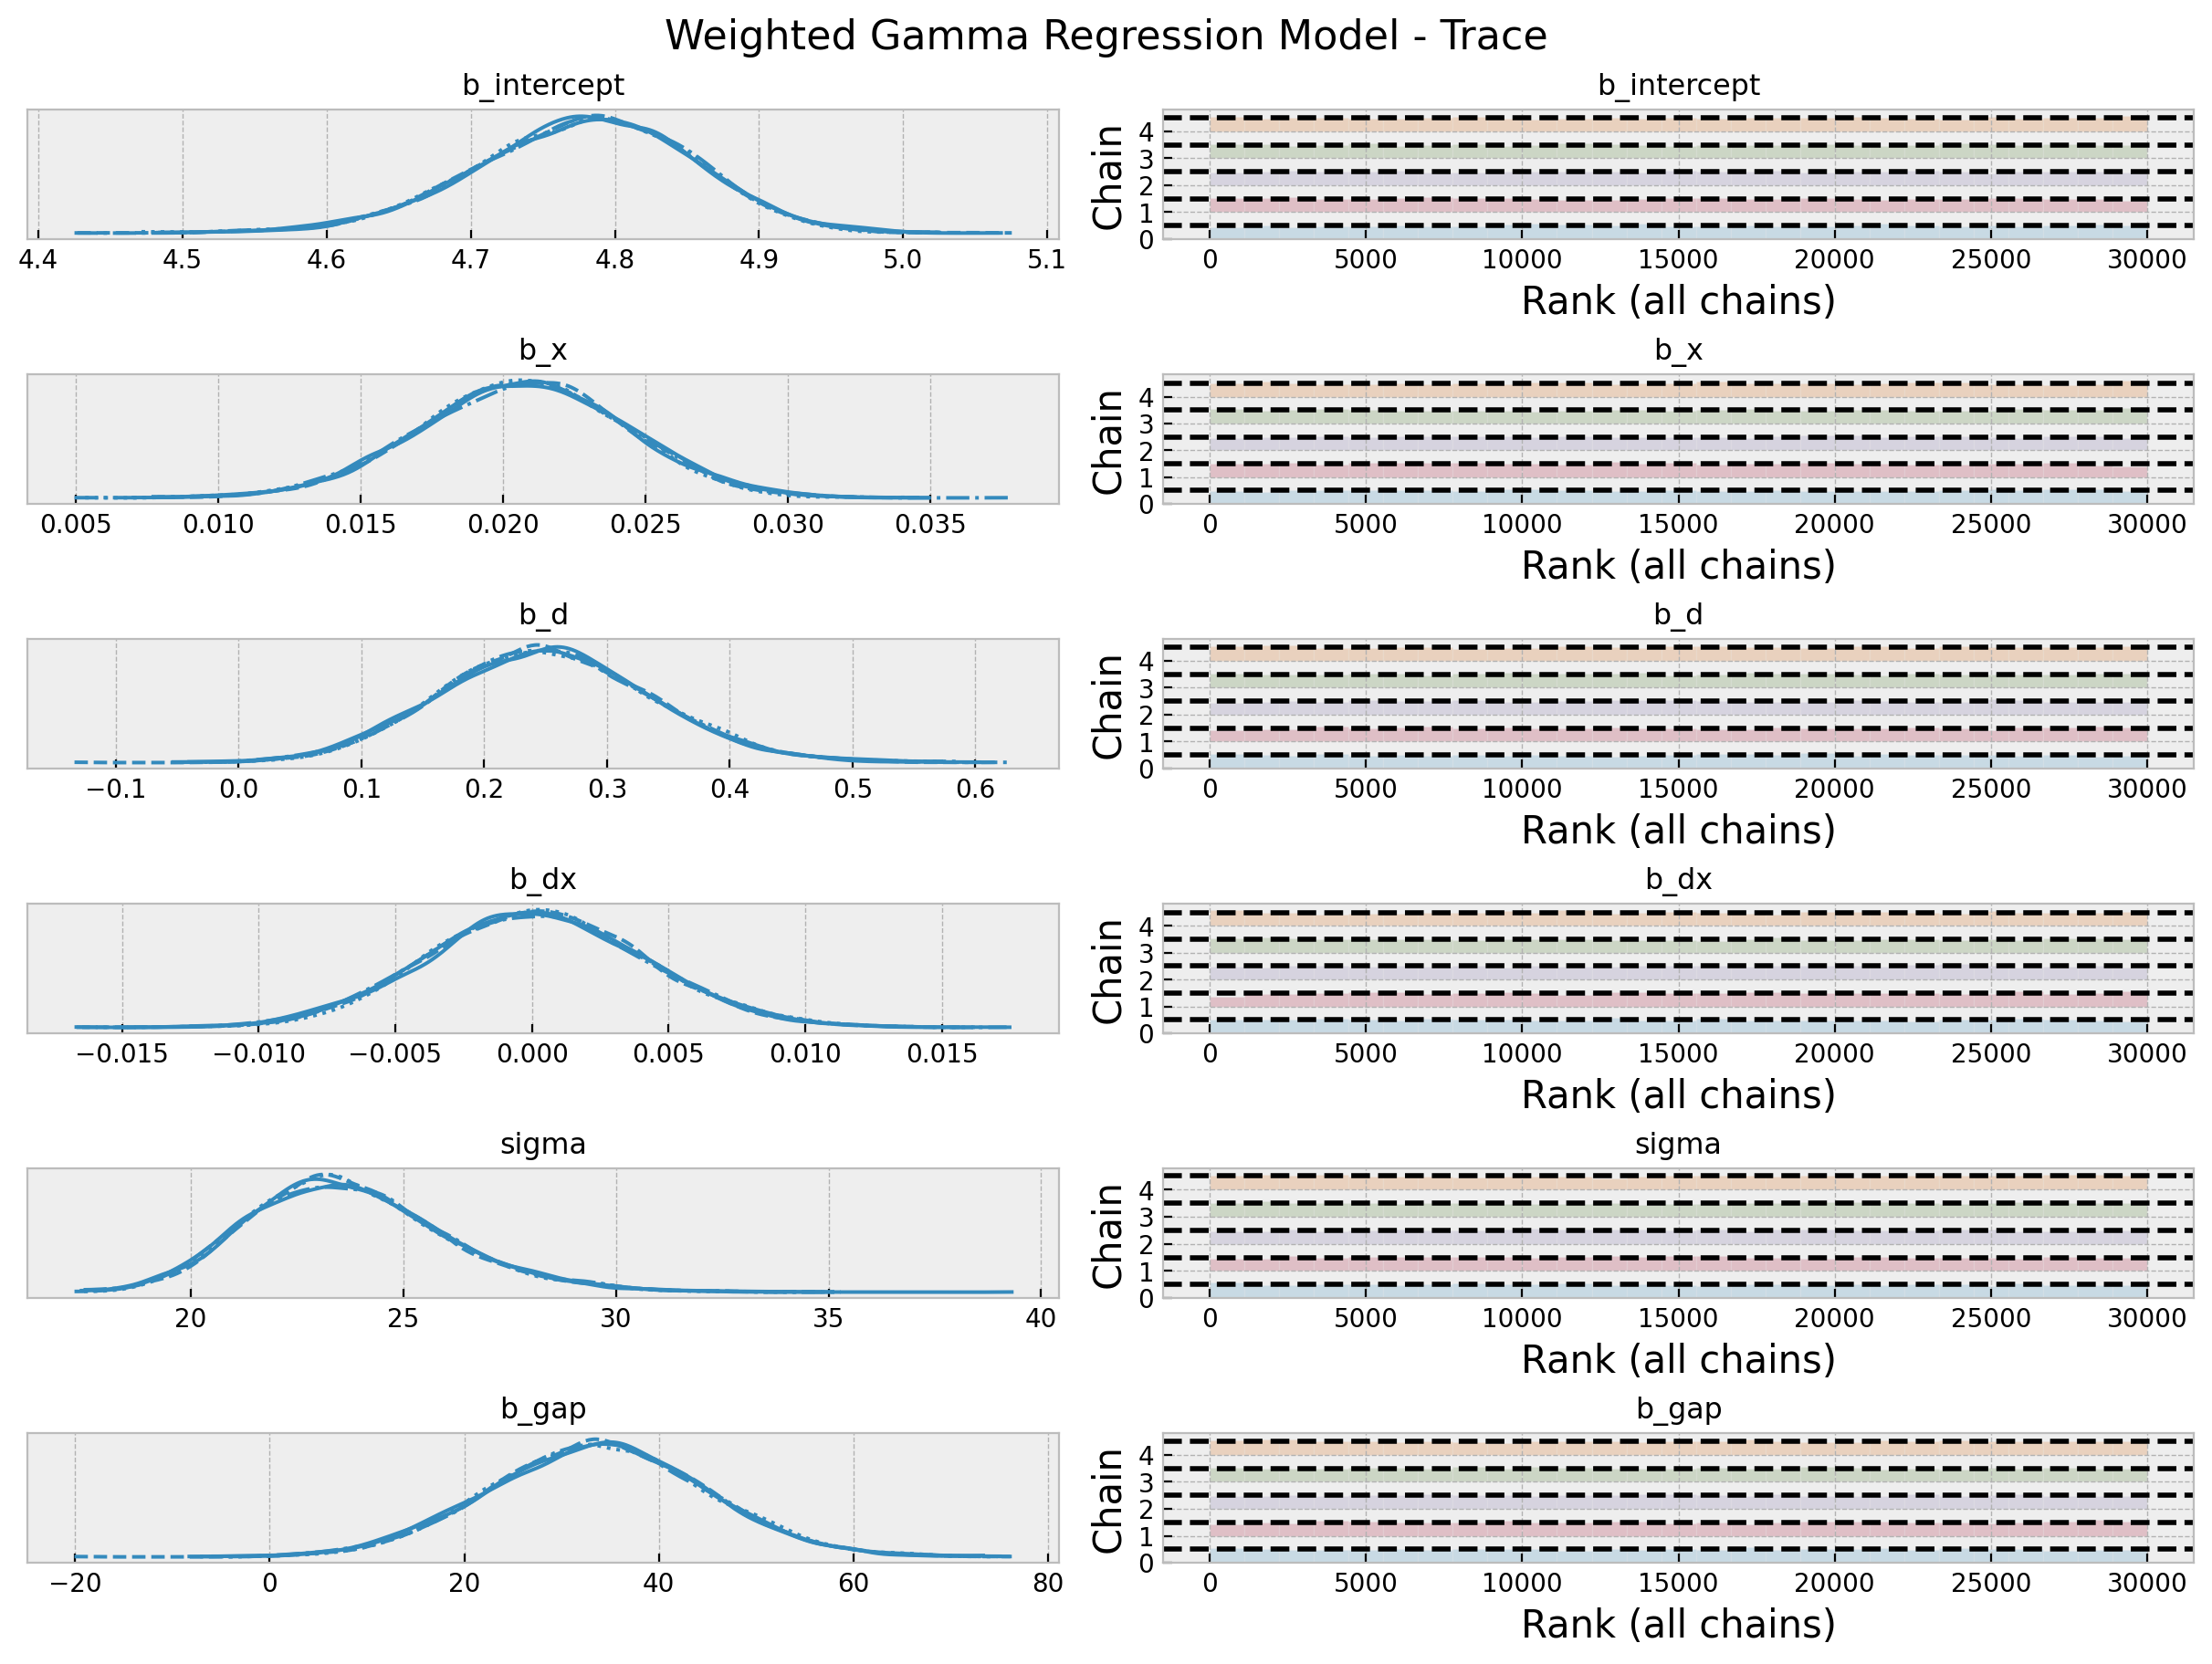

In [33]:
axes = az.plot_trace(
    data=weighted_gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Weighted Gamma Regression Model - Trace", fontsize=16)

[Text(0.5, 1.0, 'Gamma Regression Model')]

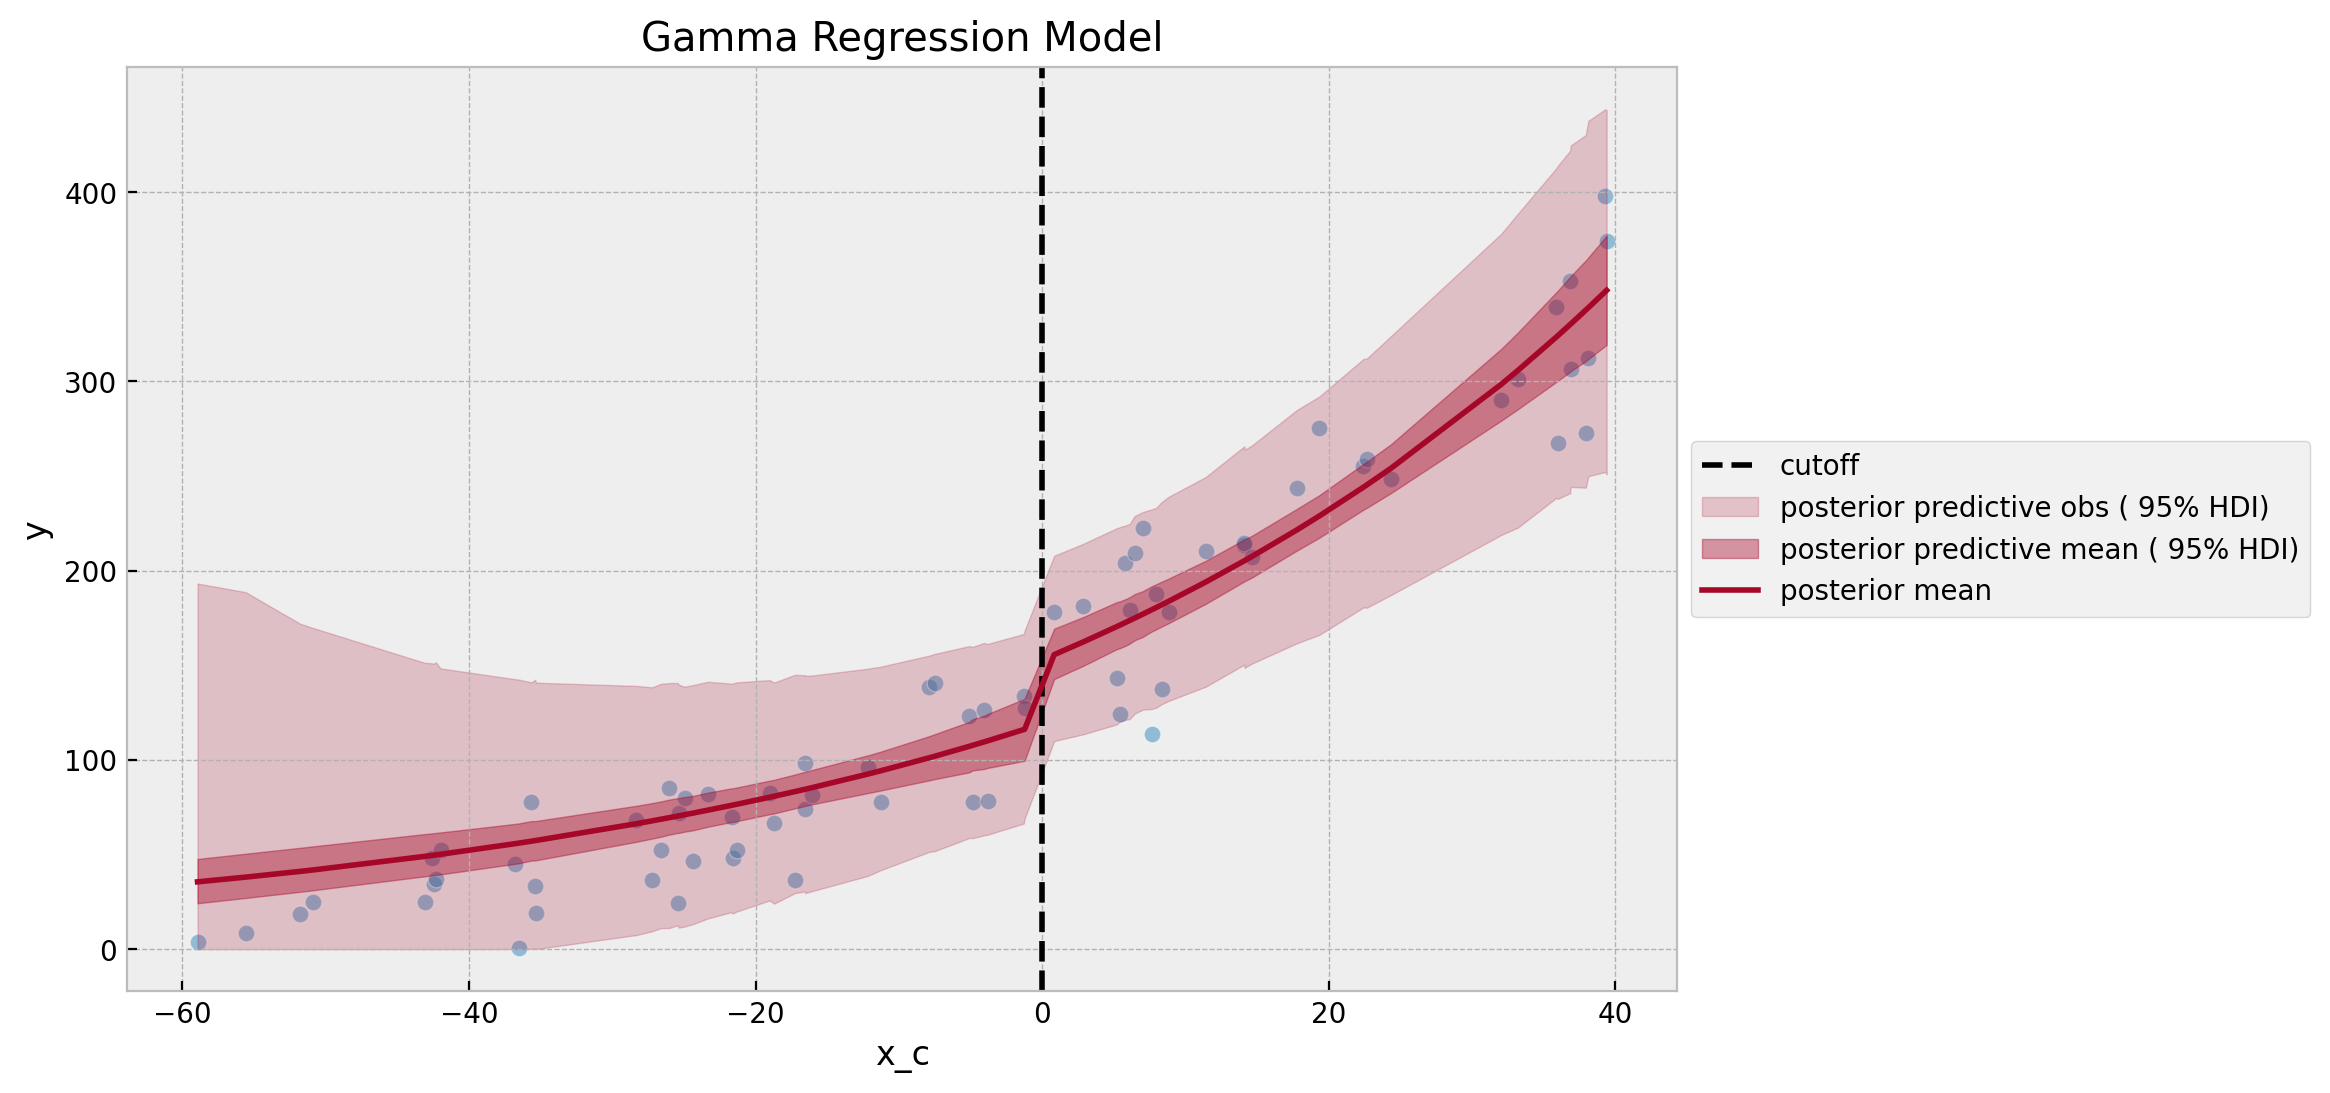

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    weighted_gamma_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    weighted_gamma_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=weighted_gamma_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model")

Text(0.5, 1.06, 'Estimated Discontinuity Posterior Distributions')

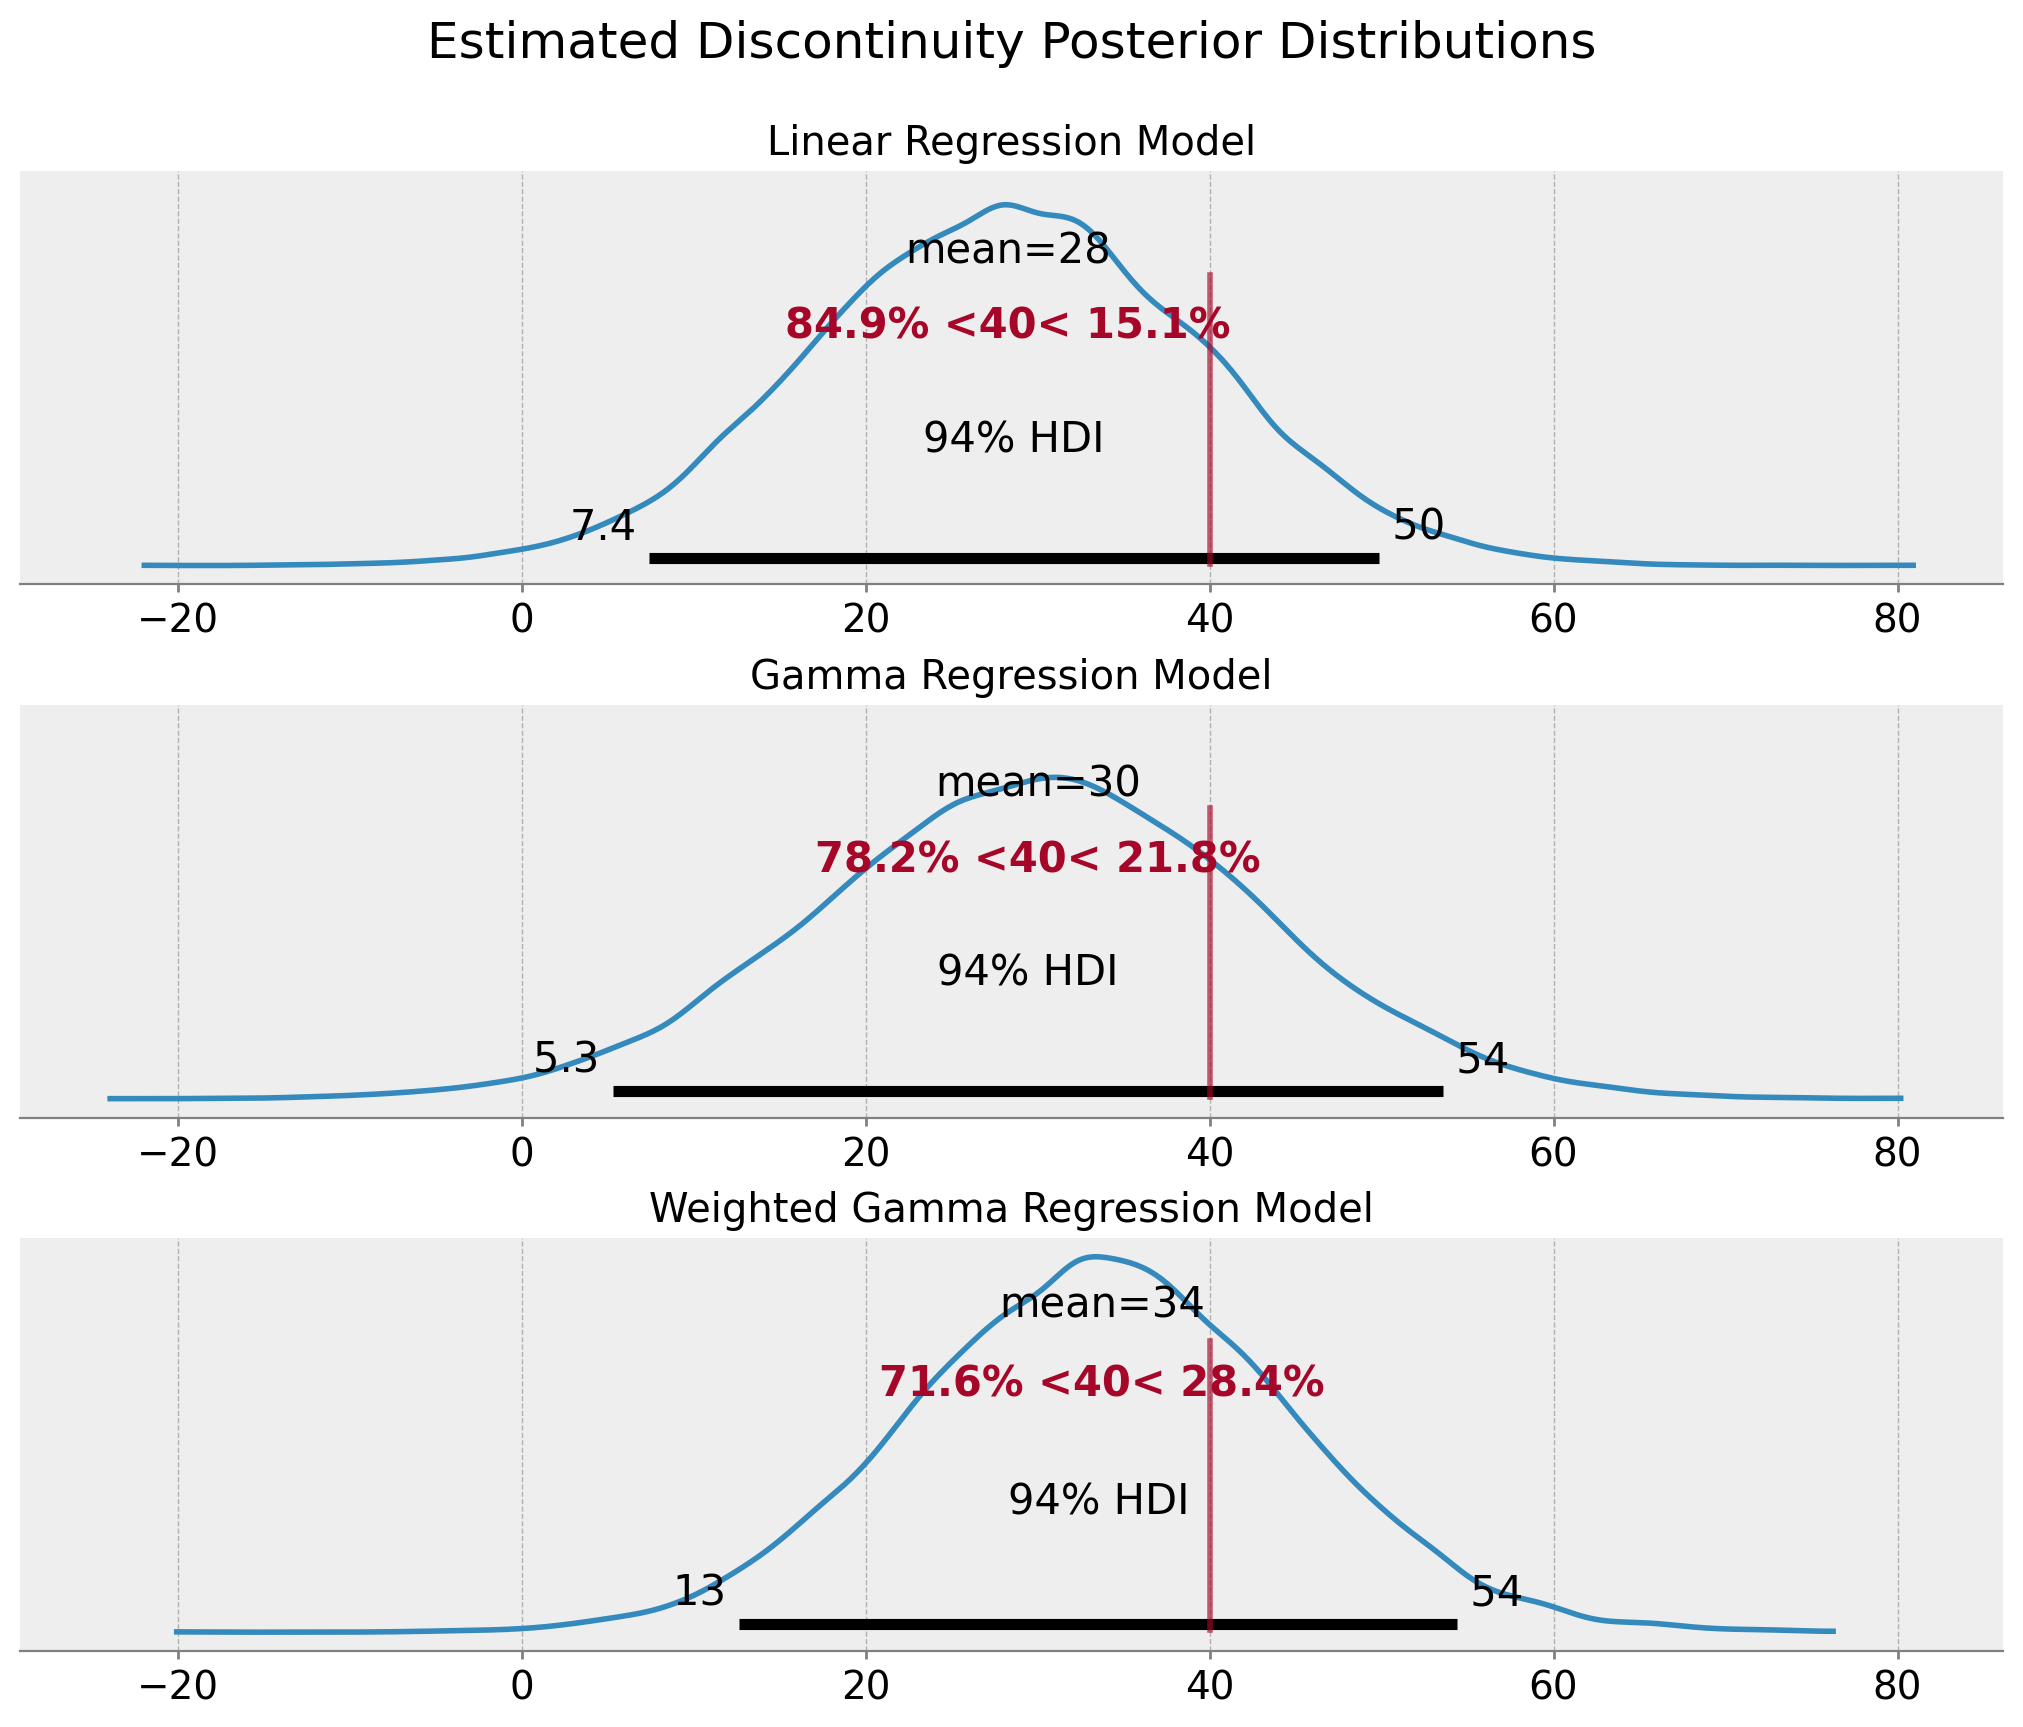

In [35]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=gaussian_idata, var_names=["b_d"], ref_val=delta_true, ax=ax[0])
ax[0].set(title="Linear Regression Model")
az.plot_posterior(data=gamma_idata, var_names=["b_gap"], ref_val=delta_true, ax=ax[1])
ax[1].set(title="Gamma Regression Model")
az.plot_posterior(
    data=weighted_gamma_idata, var_names=["b_gap"], ref_val=delta_true, ax=ax[2]
)
ax[2].set(title="Weighted Gamma Regression Model")
fig.suptitle("Estimated Discontinuity Posterior Distributions", fontsize=18, y=1.06)

Text(0.5, 1.05, 'Posterior Predictive Check')

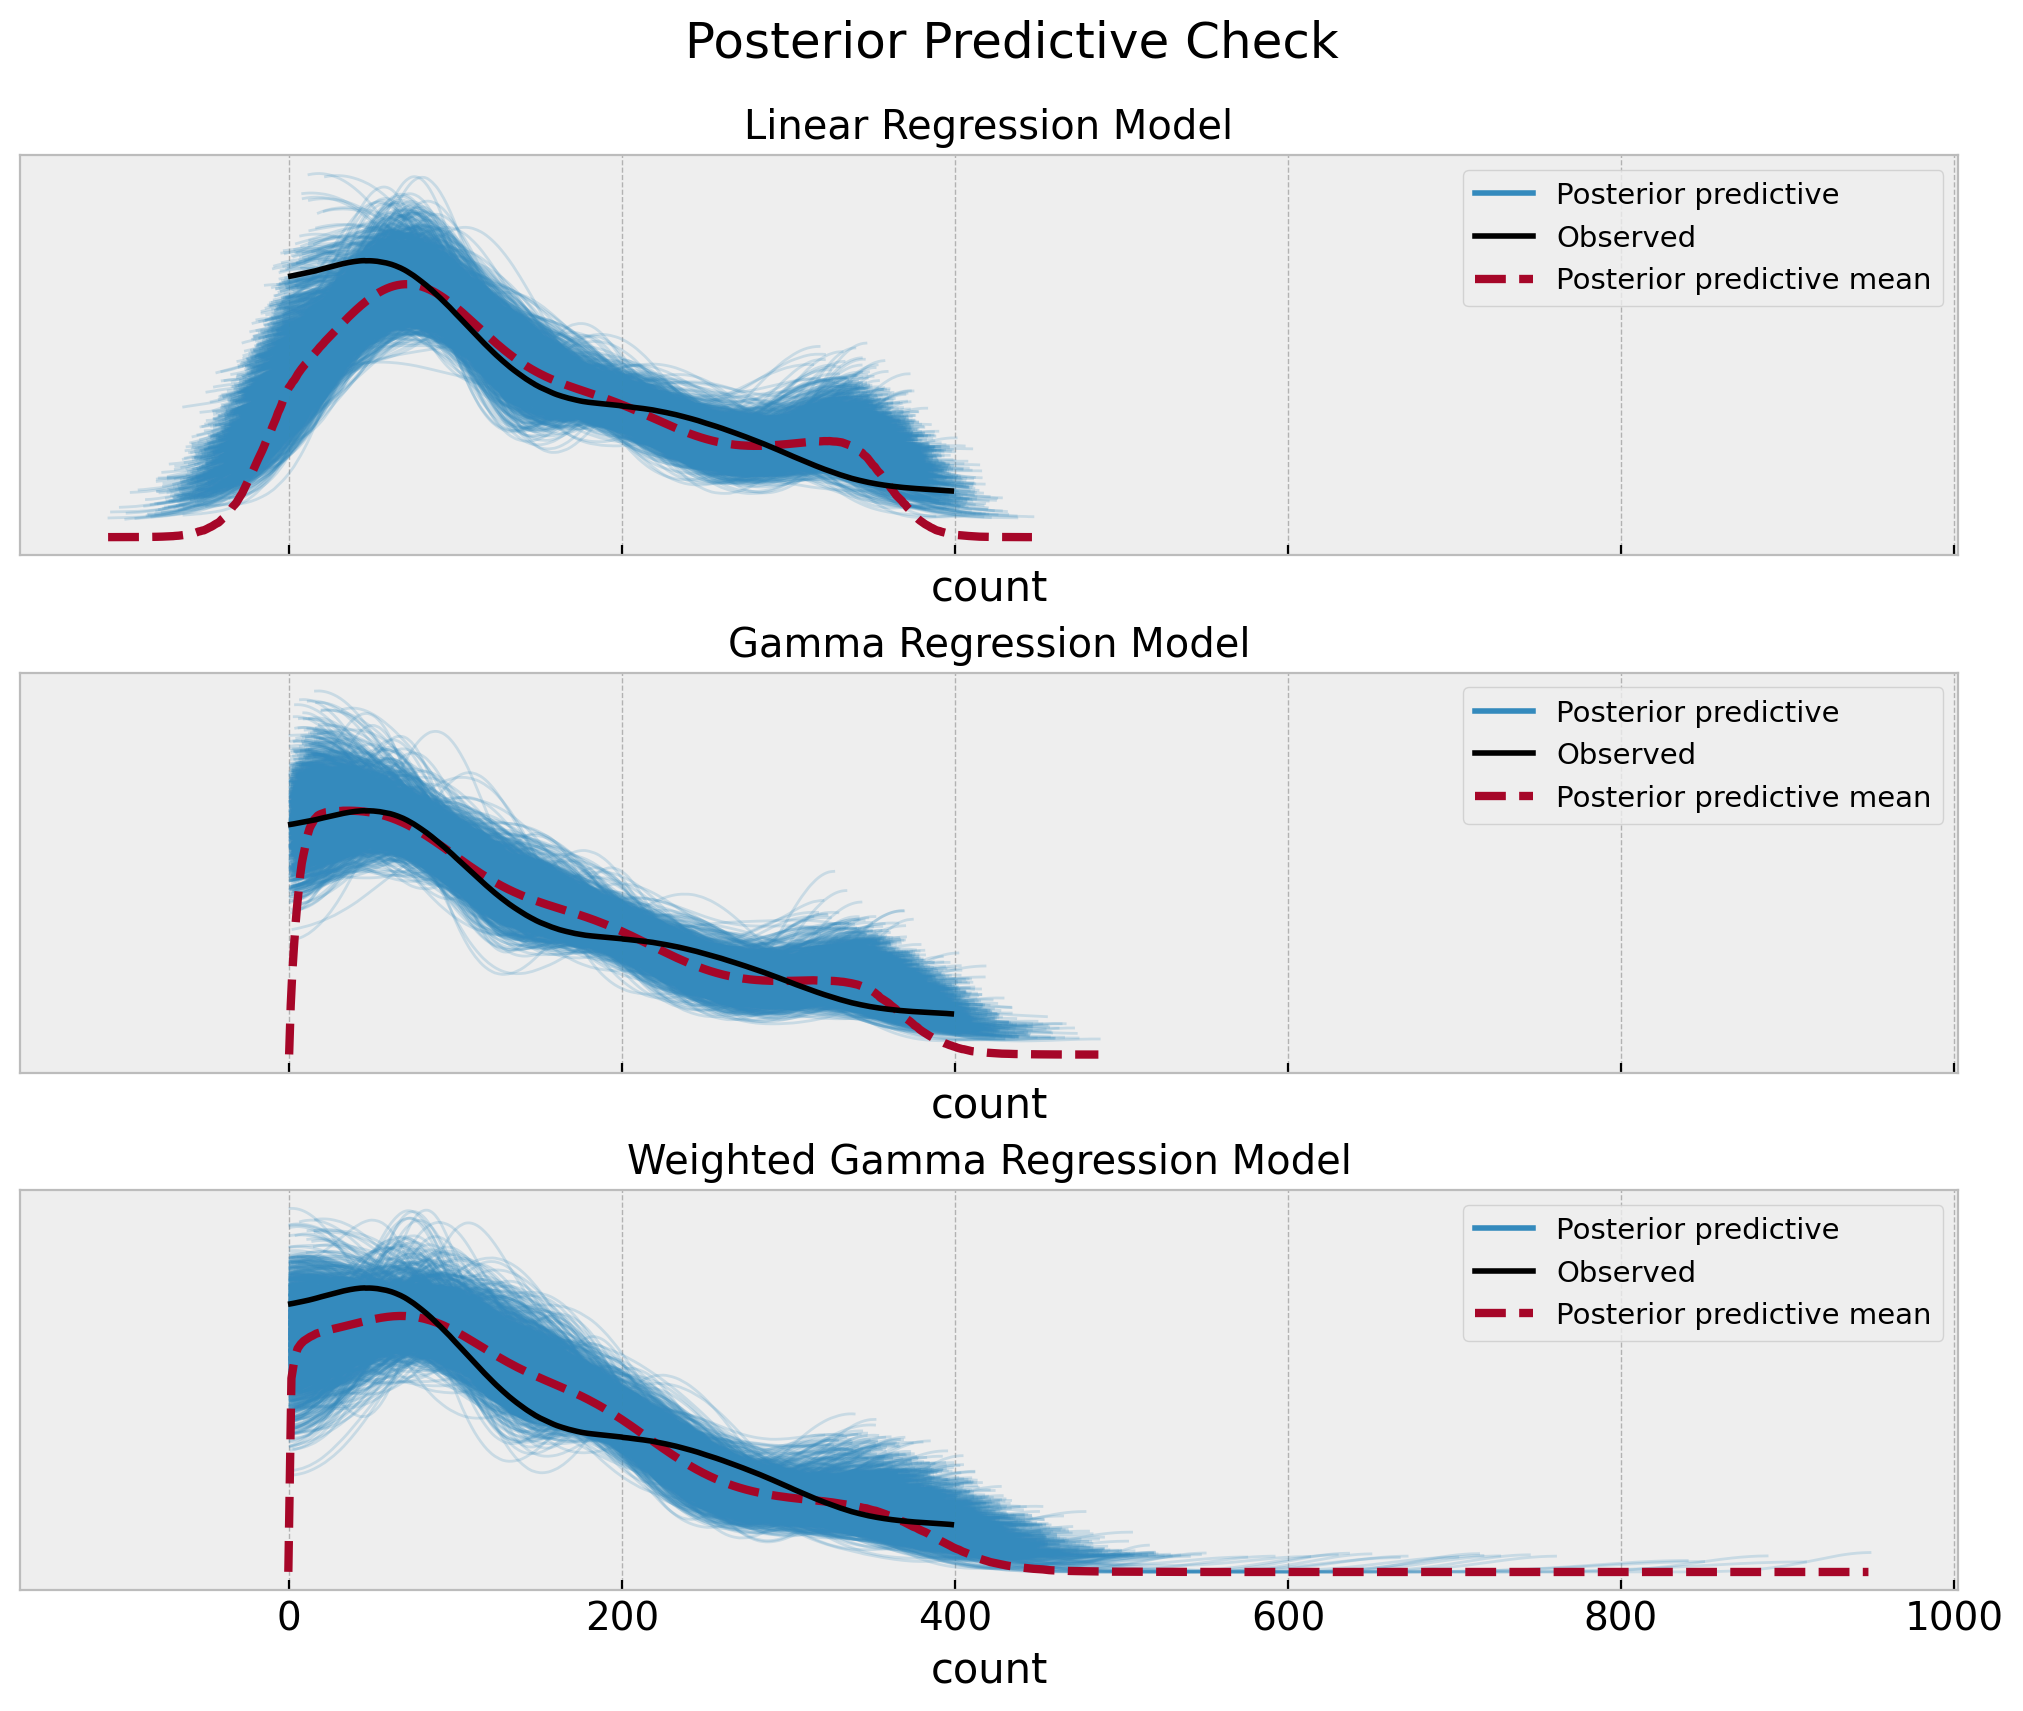

In [38]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, sharex=True, sharey=False, figsize=(10, 8), layout="constrained"
)
az.plot_ppc(
    data=gaussian_posterior_predictive, num_pp_samples=2_000, random_seed=seed, ax=ax[0]
)
ax[0].set(title="Linear Regression Model", xlabel="count")
az.plot_ppc(
    data=gamma_posterior_predictive, num_pp_samples=2_000, random_seed=seed, ax=ax[1]
)
ax[1].set(title="Gamma Regression Model", xlabel="count")
az.plot_ppc(
    data=weighted_gamma_posterior_predictive,
    num_pp_samples=2_000,
    random_seed=seed,
    ax=ax[2],
)
ax[2].set(title="Weighted Gamma Regression Model", xlabel="count")
fig.suptitle("Posterior Predictive Check", y=1.05, fontsize=18)
